/tmp/ipykernel_30260/3748606120.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


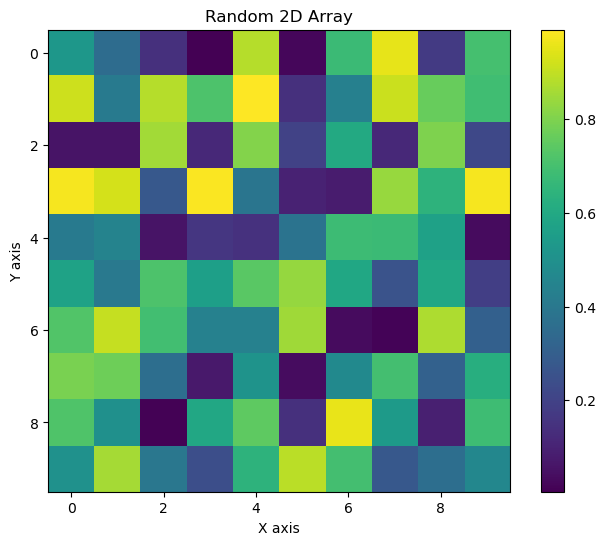

In [1]:
import sys
import os
import argparse
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

import modules.spikingjelly;
from modules.spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from modules.spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from modules.spikingjelly.datasets.n_mnist import NMNIST
# from modules.spikingjelly.datasets.es_imagenet import ESImageNet
from modules.spikingjelly.datasets import split_to_train_test_set
from modules.spikingjelly.datasets.n_caltech101 import NCaltech101
from modules.spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import modules.torchneuromorphic as torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz
from turtle import shape



In [2]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [3]:


def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,

                    synapse_trace_const1 = 1,
                    synapse_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,

                    pre_trained = False,
                    convTrue_fcFalse = True,

                    cfg = [64, 64],
                    net_print = False, # True # False
                    
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = False, # DECREPATED # fALSE

                    dvs_clipping = 1, 
                    dvs_duration = 25_000,


                    DFA_on = False, # True # False
                    trace_on = False, 
                    OTTT_input_trace_on = False, # True # False
                    
                    exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

                    merge_polarities = False, # True # False # tonic dvs dataset 에서 polarities 합치기
                    denoise_on = True, 

                    extra_train_dataset = 0, # DECREPATED # data_loader에서 train dataset을 몇개 더 쓸건지 

                    num_workers = 2,
                    chaching_on = True,
                    pin_memory = True, # True # False
                    
                    UDA_on = False,  # DECREPATED # uda
                    alpha_uda = 1.0, # DECREPATED # uda

                    bias = True,

                    last_lif = False,
                        
                    temporal_filter = 1, 
                    initial_pooling = 1,

                    temporal_filter_accumulation = False,

                    quantize_bit_list=[],
                    scale_exp=[],
                    ):
    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    print('param', hyperparameters,'\n')
    hyperparameters['current epoch'] = 0
    ######################################################################################

    ## hyperparameter check #############################################################
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False 
    # assert single_step == DFA_on, 'DFA랑 single_step공존하게해라'
    if trace_on:
        assert BPTT_on == False and single_step == True
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True #and trace_on == True
    if temporal_filter > 1:
        assert convTrue_fcFalse == False
    ######################################################################################


    

    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    wandb.config.update(hyperparameters)
    wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
    wandb.define_metric("summary_val_acc", summary="max")
    # wandb.run.log_code(".", 
    #                     include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"),
    #                     exclude_fn=lambda path: 'logs/' in path or 'net_save/' in path or 'result_save/' in path or 'trying/' in path or 'wandb/' in path or 'private/' in path or '.git/' in path or 'tonic' in path or 'torchneuromorphic' in path or 'spikingjelly' in path 
    #                     )
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_data_split_indices = []
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM, train_data_count = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME*temporal_filter, 
            dvs_clipping,
            dvs_duration,
            exclude_class,
            merge_polarities,
            denoise_on,
            my_seed,
            extra_train_dataset,
            num_workers,
            chaching_on,
            pin_memory,
            train_data_split_indices,) 
    synapse_fc_out_features = CLASS_NUM

    print('\nlen(train_loader):', len(train_loader), 'BATCH:', BATCH, 'train_data_count:', train_data_count) 
    print('len(test_loader):', len(test_loader), 'BATCH:', BATCH)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\ndevice ==> {device}\n")
    if device == "cpu":
        print("="*50,"\n[WARNING]\n[WARNING]\n[WARNING]\n: cpu mode\n\n","="*50)

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        net = REBORN_MY_SNN_FC(cfg, synapse_conv_in_channels*temporal_filter, IMAGE_SIZE//initial_pooling, synapse_fc_out_features,
                    synapse_trace_const1, synapse_trace_const2, 
                    lif_layer_v_init, lif_layer_v_decay, 
                    lif_layer_v_threshold, lif_layer_v_reset,
                    lif_layer_sg_width,
                    tdBN_on,
                    BN_on, TIME,
                    surrogate,
                    BPTT_on,
                    DFA_on,
                    bias,
                    single_step,
                    last_lif,
                    trace_on,
                    quantize_bit_list,
                    scale_exp).to(device)
    else:
        net = REBORN_MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE//initial_pooling,
                    synapse_conv_kernel_size, synapse_conv_stride, 
                    synapse_conv_padding, synapse_trace_const1, 
                    synapse_trace_const2, 
                    lif_layer_v_init, lif_layer_v_decay, 
                    lif_layer_v_threshold, lif_layer_v_reset,
                    lif_layer_sg_width,
                    synapse_fc_out_features, 
                    tdBN_on,
                    BN_on, TIME,
                    surrogate,
                    BPTT_on,
                    DFA_on,
                    bias,
                    single_step,
                    last_lif,
                    trace_on,
                    quantize_bit_list,
                    scale_exp).to(device)

    net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        # 1. 전체 state_dict 로드
        checkpoint = torch.load(pre_trained_path)

        # 2. 현재 모델의 state_dict 가져오기
        model_dict = net.state_dict()

        # 3. 'SYNAPSE'가 포함된 key만 필터링 (현재 모델에도 존재하는 key만)
        filtered_dict = {k: v for k, v in checkpoint.items() if ('weight' in k or 'bias' in k) and k in model_dict}

        # 4. 업데이트된 키 출력
        print("🔄 업데이트된 SYNAPSE 관련 레이어들:")
        for k in filtered_dict.keys():
            print(f" - {k}")

        # 5. 모델 dict 업데이트 및 로딩
        model_dict.update(filtered_dict)
        net.load_state_dict(model_dict)
    
    net = net.to(device)
    if (net_print == True):
        print(net)    

    print(f"\n========================================================\nTrainable parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad):,}\n========================================================\n")
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    # wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## criterion ########################################## # loss 구해주는 친구
    def my_cross_entropy_loss(logits, targets):
        # logits: (batch_size, num_classes)
        # targets: (batch_size,) -> 클래스 인덱스
        log_probs = F.log_softmax(logits, dim=1)  # log(p_i)
        loss = F.nll_loss(log_probs, targets)
        # print(loss.shape)
        return loss
    
    class CustomLossFunction(torch.autograd.Function):
        @staticmethod
        def forward(ctx, input, target):
            ctx.save_for_backward(input, target)
            return F.cross_entropy(input, target)

        @staticmethod
        def backward(ctx, grad_output):
            # MAE 스타일의 gradient를 흉내냄
            input, target = ctx.saved_tensors
            input_argmax = input.argmax(dim=1)
            input_one_hot = torch.zeros_like(input).scatter_(1, input_argmax.unsqueeze(1), 1.0)
            target_one_hot = torch.zeros_like(input).scatter_(1, target.unsqueeze(1), 1.0)
            # print('grad_output', grad_output) # 이거 걍 1.0임
            return input_one_hot - target_one_hot, None  # target에는 gradient 없음

    # Wrapper module
    class CustomCriterion(torch.nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self, input, target):
            return CustomLossFunction.apply(input, target)

    # criterion = nn.CrossEntropyLoss().to(device)
    criterion = CustomCriterion().to(device)
    
    # if (OTTT_sWS_on == True):
    #     # criterion = nn.CrossEntropyLoss().to(device)
        # criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    #     if which_data == 'DVS_GESTURE':
    #         criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################

    ## optimizer, scheduler ########################################################################
    class MySGD(torch.optim.Optimizer):
        def __init__(self, params, lr=0.01, momentum=0.0):
            if momentum < 0.0 or momentum >= 1.0:
                raise ValueError(f"Invalid momentum value: {momentum}")
            
            defaults = {'lr': lr, 'momentum': momentum}
            super(MySGD, self).__init__(params, defaults)

        @torch.no_grad()
        def step(self):
            """모든 파라미터에 대해 gradient descent 수행"""
            loss = None
            for group in self.param_groups:
                lr = group['lr']
                momentum = group['momentum']
                for param in group['params']:
                    if param.grad is None:
                        continue
                    # gradient를 이용해 파라미터 업데이트
                    d_p = param.grad

                    if momentum > 0.0:
                        param_state = self.state[param]
                        if 'momentum_buffer' not in param_state:
                            # momentum buffer 초기화
                            buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                        else:
                            buf = param_state['momentum_buffer']
                            buf.mul_(momentum).add_(d_p)
                            # buf *= momentum 
                            # buf += d_p
                        d_p = buf

                    param.add_(d_p, alpha=-lr)
                    # param -= lr * d_p 
            return loss
    
    if(optimizer_what == 'SGD'):
        optimizer = MySGD(net.parameters(), lr=learning_rate, momentum=0.0)
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.0)
        print(optimizer)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=epoch_num)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    tr_acc_best = 0
    tr_epoch_loss_temp = 0
    tr_epoch_loss = 0
    val_acc_best = 0
    val_acc_now = 0
    val_loss = 0
    iter_of_val = False
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if epoch == 1:
            for name, module in net.named_modules():
                if isinstance(module, Feedback_Receiver):
                    print(f"[{name}] weight_fb parameter count: {module.weight_fb.numel():,}")

        max_val_box = []
        max_val_scale_exp_8bit_box = []
        max_val_scale_exp_16bit_box = []
        perc_95_box = []
        perc_95_scale_exp_8bit_box = []
        perc_95_scale_exp_16bit_box = []
        perc_99_box = []
        perc_99_scale_exp_8bit_box = []
        perc_99_scale_exp_16bit_box = []
        perc_999_box = []
        perc_999_scale_exp_8bit_box = []
        perc_999_scale_exp_16bit_box = []
        ##### weight 프린트 ######################################################################
        for name, param in net.module.named_parameters():
            if 'weight' in name or 'bias' in name:
                
                data = param.detach().cpu().numpy().flatten()
                abs_data = np.abs(data)

                # 통계량 계산
                mean = np.mean(data)
                std = np.std(data)
                abs_mean = np.mean(abs_data)
                abs_std = np.std(abs_data)
                eps = 1e-15

                # 절대값 기반 max, percentiles
                max_val = abs_data.max()
                max_val_scale_exp_8bit = math.ceil(math.log2((eps+max_val)/ (2**(8-1) -1)))
                max_val_scale_exp_16bit = math.ceil(math.log2((eps+max_val)/ (2**(16-1) -1)))
                perc_95 = np.percentile(abs_data, 95)
                perc_95_scale_exp_8bit = math.ceil(math.log2((eps+perc_95)/ (2**(8-1) -1)))
                perc_95_scale_exp_16bit = math.ceil(math.log2((eps+perc_95)/ (2**(16-1) -1)))
                perc_99 = np.percentile(abs_data, 99)
                perc_99_scale_exp_8bit = math.ceil(math.log2((eps+perc_99)/ (2**(8-1) -1)))
                perc_99_scale_exp_16bit = math.ceil(math.log2((eps+perc_99)/ (2**(16-1) -1)))
                perc_999 = np.percentile(abs_data, 99.9)
                perc_999_scale_exp_8bit = math.ceil(math.log2((eps+perc_999)/ (2**(8-1) -1)))
                perc_999_scale_exp_16bit = math.ceil(math.log2((eps+perc_999)/ (2**(16-1) -1)))
                
                max_val_box.append(max_val)
                max_val_scale_exp_8bit_box.append(max_val_scale_exp_8bit)
                max_val_scale_exp_16bit_box.append(max_val_scale_exp_16bit)
                perc_95_box.append(perc_95)
                perc_95_scale_exp_8bit_box.append(perc_95_scale_exp_8bit)
                perc_95_scale_exp_16bit_box.append(perc_95_scale_exp_16bit)
                perc_99_box.append(perc_99)
                perc_99_scale_exp_8bit_box.append(perc_99_scale_exp_8bit)
                perc_99_scale_exp_16bit_box.append(perc_99_scale_exp_16bit)
                perc_999_box.append(perc_999)
                perc_999_scale_exp_8bit_box.append(perc_999_scale_exp_8bit)
                perc_999_scale_exp_16bit_box.append(perc_999_scale_exp_16bit)




                # if epoch % 5 == 0 or epoch < 3:
                #     print("=> Plotting weight and bias distributions...")
                #     # 그래프 그리기
                #     plt.figure(figsize=(6, 4))
                #     plt.hist(data, bins=100, alpha=0.7, color='skyblue')
                #     plt.axvline(x=max_val, color='red', linestyle='--', label=f'Max: {max_val:.4f}')
                #     plt.axvline(x=-max_val, color='red', linestyle='--')
                #     plt.axvline(x=perc_95, color='green', linestyle='--', label=f'95%: {perc_95:.4f}')
                #     plt.axvline(x=-perc_95, color='green', linestyle='--')
                #     plt.axvline(x=perc_99, color='orange', linestyle='--', label=f'99%: {perc_99:.4f}')
                #     plt.axvline(x=-perc_99, color='orange', linestyle='--')
                #     plt.axvline(x=perc_999, color='purple', linestyle='--', label=f'99.9%: {perc_999:.4f}')
                #     plt.axvline(x=-perc_999, color='purple', linestyle='--')
                    
                #     # 제목에 통계값 포함
                #     title = (
                #         f"{name}, Epoch {epoch}\n"
                #         f"mean={mean:.4f}, std={std:.4f}, "
                #         f"|mean|={abs_mean:.4f}, |std|={abs_std:.4f}\n"
                #         f"Scale 8bit max = { max_val_scale_exp_8bit}, "
                #         f"Scale 16bit max = {max_val_scale_exp_16bit}\n"
                #         f"Scale 8bit p999 = {perc_95_scale_exp_8bit }, "
                #         f"Scale 16bit p999 = {perc_95_scale_exp_16bit }\n"
                #         f"Scale 8bit p99 = {perc_99_scale_exp_8bit }, "
                #         f"Scale 16bit p99 = { perc_99_scale_exp_16bit}\n"
                #         f"Scale 8bit p95 = { perc_999_scale_exp_8bit}, "
                #         f"Scale 16bit p95 = { perc_999_scale_exp_16bit}"
                #     )
                #     plt.title(title)
                #     plt.xlabel('Value')
                #     plt.ylabel('Frequency')
                #     plt.grid(True)
                #     plt.legend()
                #     plt.tight_layout()
                #     plt.show()
        ##### weight 프린트 ######################################################################

        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        # iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   

        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            net.train() # train 모드로 바꿔줘야함
            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
            else:
                assert False, 'data length is not 2 or 3'
            #######################################################################################################################
                
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            # 차원 전처리
            ###########################################################################################################################        
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                


                            
            ## initial pooling #######################################################################
            if (initial_pooling > 1):
                pool = nn.MaxPool2d(kernel_size=2)
                num_pooling_layers = int(math.log2(initial_pooling))
                # Time, Batch, Channel 차원은 그대로 두고, Height, Width 차원에 대해서만 pooling 적용
                shape_temp = inputs.shape
                inputs = inputs.reshape(shape_temp[0]*shape_temp[1], shape_temp[2], shape_temp[3], shape_temp[4])
                for _ in range(num_pooling_layers):
                    inputs = pool(inputs)
                inputs = inputs.reshape(shape_temp[0], shape_temp[1], shape_temp[2], shape_temp[3]//initial_pooling, shape_temp[4]//initial_pooling)
            ## initial pooling #######################################################################
            ## temporal filtering ####################################################################
            shape_temp = inputs.shape
            if (temporal_filter > 1):
                slice_bucket = []
                for t_temp in range(TIME):
                    start = t_temp * temporal_filter
                    end = start + temporal_filter
                    slice_concat = torch.movedim(inputs[start:end], 0, -2).reshape(shape_temp[1],shape_temp[2],shape_temp[3],-1)
                    
                    if temporal_filter_accumulation == True:
                        if t_temp == 0:
                            slice_bucket.append(slice_concat)
                        else:
                            slice_bucket.append(slice_concat+slice_bucket[t_temp-1])
                    else:
                        slice_bucket.append(slice_concat)

                inputs = torch.stack(slice_bucket, dim=0)
                if temporal_filter_accumulation == True and dvs_clipping > 0:
                    inputs = (inputs != 0.0).float()
            ## temporal filtering ####################################################################
            ####################################################################################################################### 
                

            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################

            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
                            
            if merge_polarities == True:
                inputs = inputs[:,:,0:1,:,:]

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if trace_on == True and OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_trace_const2 + spike[t]*synapse_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################


            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                iter_loss = criterion(outputs, labels)
                iter_loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                iter_loss = 0.0
                for t in range(TIME):
                    ### input[t] --> net --> output_one_time #########################################
                    outputs_one_time = net(inputs[t])
                    ##################################################################################
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    iter_loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                iter_loss /= TIME

            tr_epoch_loss_temp += iter_loss.data/len(train_loader)

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            iter_acc_string = f'epoch-{epoch:<3} iter_acc:{100 * iter_acc:7.2f}%, lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            iter_acc_string2 = f'epoch-{epoch:<3} lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            

            ##### validation ##################################################################################################################################
            if i == len(train_loader)-1 :
                iter_of_val = True

                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0

                val_loss = 0
                correct_val = 0
                total_val = 0

                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data_val in test_loader:
                        ## data_val loading & semi-pre-processing ##########################################################
                        if len(data_val) == 2:
                            inputs_val, labels_val = data_val
                        elif len(data_val) == 3:
                            inputs_val, labels_val, x_len = data_val
                        else:
                            assert False, 'data_val length is not 2 or 3'

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs_val = inputs_val.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs_val = spikegen.rate(inputs_val, num_steps=TIME)
                        else :
                            inputs_val = inputs_val.repeat(TIME, 1, 1, 1, 1)
                        # inputs_val: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        
                        ## initial pooling #######################################################################
                        if (initial_pooling > 1):
                            pool = nn.MaxPool2d(kernel_size=2)
                            num_pooling_layers = int(math.log2(initial_pooling))
                            # Time, Batch, Channel 차원은 그대로 두고, Height, Width 차원에 대해서만 pooling 적용
                            shape_temp = inputs_val.shape
                            inputs_val = inputs_val.reshape(shape_temp[0]*shape_temp[1], shape_temp[2], shape_temp[3], shape_temp[4])
                            for _ in range(num_pooling_layers):
                                inputs_val = pool(inputs_val)
                            inputs_val = inputs_val.reshape(shape_temp[0], shape_temp[1], shape_temp[2], shape_temp[3]//initial_pooling, shape_temp[4]//initial_pooling)
                        ## initial pooling #######################################################################

                        ## temporal filtering ####################################################################
                        shape_temp = inputs_val.shape
                        if (temporal_filter > 1):
                            slice_bucket = []
                            for t_temp in range(TIME):
                                start = t_temp * temporal_filter
                                end = start + temporal_filter
                                slice_concat = torch.movedim(inputs_val[start:end], 0, -2).reshape(shape_temp[1],shape_temp[2],shape_temp[3],-1)
                                
                                if temporal_filter_accumulation == True:
                                    if t_temp == 0:
                                        slice_bucket.append(slice_concat)
                                    else:
                                        slice_bucket.append(slice_concat+slice_bucket[t_temp-1])
                                else:
                                    slice_bucket.append(slice_concat)

                            inputs_val = torch.stack(slice_bucket, dim=0)
                            if temporal_filter_accumulation == True and dvs_clipping > 0:
                                inputs = (inputs != 0.0).float()
                        ## temporal filtering ####################################################################
                            
                        inputs_val = inputs_val.to(device)
                        labels_val = labels_val.to(device)
                        real_batch = labels_val.size(0)
                        
                        if merge_polarities == True:
                            inputs_val = inputs_val[:,:,0:1,:,:]

                        ## network 연산 시작 ############################################################################################################
                        if single_step == False:
                            outputs = net(inputs_val.permute(1, 0, 2, 3, 4)) #inputs_val: [Batch, Time, Channel, Height, Width]  
                            val_loss += criterion(outputs, labels_val)/len(test_loader)
                        else:
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs_val[t])
                                val_loss_temp = criterion(outputs, labels_val)
                                outputs_all.append(outputs.detach())
                                val_loss += (val_loss_temp.data/TIME)/len(test_loader)
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)
                        #################################################################################################################################

                        _, predicted = torch.max(outputs.data, 1)
                        total_val += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct_val += (predicted == labels_val).sum().item()

                    val_acc_now = correct_val / total_val

                if val_acc_best < val_acc_now:
                    val_acc_best = val_acc_now
                    # wandb 키면 state_dict아닌거는 저장 안됨
                    # network save
                    torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")

                if tr_acc_best < tr_acc:
                    tr_acc_best = tr_acc

                tr_epoch_loss = tr_epoch_loss_temp
                tr_epoch_loss_temp = 0

            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if iter_of_val == False:
                # iterator.set_description(f"{iter_acc_string}, iter_loss:{iter_loss:10.6f}") 
                pass 
            else:
                # iterator.set_description(f"{iter_acc_string2}, tr/val_loss:{tr_epoch_loss:10.6f}/{val_loss:10.6f}, tr:{100 * tr_acc:7.2f}%, tr_best:{100 * tr_acc_best:7.2f}%, val:{100 * val_acc_now:7.2f}%, val_best:{100 * val_acc_best:7.2f}%")  
                print(f"{iter_acc_string2}, tr/val_loss:{tr_epoch_loss:10.6f}/{val_loss:10.6f}, val:{100 * val_acc_now:7.2f}%, val_best:{100 * val_acc_best:7.2f}%, tr:{100 * tr_acc:7.2f}%, tr_best:{100 * tr_acc_best:7.2f}%")
                iter_of_val = False
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            wandb.log({"iter_acc": iter_acc})
            wandb.log({"tr_acc": tr_acc})
            wandb.log({"val_acc_now": val_acc_now})
            wandb.log({"val_acc_best": val_acc_best})
            wandb.log({"summary_val_acc": val_acc_now})
            wandb.log({"epoch": epoch})
            wandb.log({"val_loss": val_loss}) 
            wandb.log({"tr_epoch_loss": tr_epoch_loss}) 
            wandb.log({"max_val_scale_exp_8bit_1w": max_val_scale_exp_8bit_box[0]}) 
            wandb.log({"max_val_scale_exp_8bit_1b": max_val_scale_exp_8bit_box[1]})
            wandb.log({"max_val_scale_exp_8bit_2w": max_val_scale_exp_8bit_box[2]}) 
            wandb.log({"max_val_scale_exp_8bit_2b": max_val_scale_exp_8bit_box[3]}) 
            wandb.log({"max_val_scale_exp_8bit_3w": max_val_scale_exp_8bit_box[4]}) 
            wandb.log({"max_val_scale_exp_8bit_3b": max_val_scale_exp_8bit_box[5]})

            wandb.log({"perc_999_scale_exp_8bit_1w": perc_999_scale_exp_8bit_box[0]}) 
            wandb.log({"perc_999_scale_exp_8bit_1b": perc_999_scale_exp_8bit_box[1]})
            wandb.log({"perc_999_scale_exp_8bit_2w": perc_999_scale_exp_8bit_box[2]}) 
            wandb.log({"perc_999_scale_exp_8bit_2b": perc_999_scale_exp_8bit_box[3]}) 
            wandb.log({"perc_999_scale_exp_8bit_3w": perc_999_scale_exp_8bit_box[4]}) 

            ####################################################################################################################################
            
        ###### ITERATION END ##########################################################################################################

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
    #======== EPOCH END ==========================================================================================


In [4]:
# unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
# wandb.init(project= f'my_snn {unique_name}',save_code=False, dir='/data2/bh_wandb', tags=["common"])
# ## wandb 과거 하이퍼파라미터 가져와서 붙여넣기 (devices unique_name은 니가 할당해라)#################################
# param = {'devices': '3', 'single_step': True, 'unique_name': 'main', 'my_seed': 42, 'TIME': 10, 'BATCH': 16, 'IMAGE_SIZE': 128, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.25, 'lif_layer_v_threshold': 0.75, 'lif_layer_v_reset': 0, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': 'net_save/save_now_net_weights_{unique_name}.pth', 'learning_rate': 0.001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 2, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': True, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': False, 'denoise_on': True, 'extra_train_dataset': 0, 'num_workers': 2, 'chaching_on': True, 'pin_memory': True, 'UDA_on': False, 'alpha_uda': 1, 'bias': True, 'last_lif': False, 'temporal_filter': 5, 'initial_pooling': 8}
# my_snn_system(devices = '0',single_step = param['single_step'],unique_name = unique_name,my_seed = param['my_seed'],TIME = param['TIME'],BATCH = param['BATCH'],IMAGE_SIZE = param['IMAGE_SIZE'],which_data = param['which_data'],data_path = param['data_path'],rate_coding = param['rate_coding'],lif_layer_v_init = param['lif_layer_v_init'],lif_layer_v_decay = param['lif_layer_v_decay'],lif_layer_v_threshold = param['lif_layer_v_threshold'],lif_layer_v_reset = param['lif_layer_v_reset'],lif_layer_sg_width = param['lif_layer_sg_width'],synapse_conv_kernel_size = param['synapse_conv_kernel_size'],synapse_conv_stride = param['synapse_conv_stride'],synapse_conv_padding = param['synapse_conv_padding'],synapse_trace_const1 = param['synapse_trace_const1'],synapse_trace_const2 = param['synapse_trace_const2'],pre_trained = param['pre_trained'],convTrue_fcFalse = param['convTrue_fcFalse'],cfg = param['cfg'],net_print = param['net_print'],pre_trained_path = param['pre_trained_path'],learning_rate = param['learning_rate'],epoch_num = param['epoch_num'],tdBN_on = param['tdBN_on'],BN_on = param['BN_on'],surrogate = param['surrogate'],BPTT_on = param['BPTT_on'],optimizer_what = param['optimizer_what'],scheduler_name = param['scheduler_name'],ddp_on = param['ddp_on'],dvs_clipping = param['dvs_clipping'],dvs_duration = param['dvs_duration'],DFA_on = param['DFA_on'],trace_on = param['trace_on'],OTTT_input_trace_on = param['OTTT_input_trace_on'],exclude_class = param['exclude_class'],merge_polarities = param['merge_polarities'],denoise_on = param['denoise_on'],extra_train_dataset = param['extra_train_dataset'],num_workers = param['num_workers'],chaching_on = param['chaching_on'],pin_memory = param['pin_memory'],UDA_on = param['UDA_on'],alpha_uda = param['alpha_uda'],bias = param['bias'],last_lif = param['last_lif'],temporal_filter = param['temporal_filter'],initial_pooling = param['initial_pooling'],temporal_filter_accumulation= param['temporal_filter_accumulation'])
# #############################################################################


In [5]:
# ### my_snn control board (Gesture) ########################
# decay = 0.5 # 0.0 # 0.875 0.25 0.125 0.75 0.5
# # nda 0.25 # ottt 0.5

# unique_name = 'main'
# run_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_") + f"{datetime.datetime.now().microsecond // 1000:03d}"


# wandb.init(project= f'my_snn {unique_name}',save_code=False, dir='/data2/bh_wandb', tags=["common"])

# my_snn_system(  devices = "1",
#                 single_step = True, # True # False # DFA_on이랑 같이 가라
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = 8, # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = 16, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = 14, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = 'DVS_GESTURE_TONIC',
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','CIFAR10','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False

#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 0.5,   #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 10000.0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 4.0, # 2.570969004857107 # sigmoid류에서는 alpha값 4.0, rectangle류에서는 width값 0.5

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,

#                 synapse_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_trace_const2 = decay, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = ['M', 'M', 32, 'P', 32, 'P', 32, 'P'], 
#                 # cfg = ['M', 'M', 64, 'P', 64, 'P', 64, 'P'], 
#                 # cfg = ['M', 'M', 64, 'M', 96, 'M', 128, 'M'], 
#                 cfg = [200, 200], 
#                 # cfg = ['M', 'M', 64, 'M', 96], 
#                 # cfg = ['M', 'M', 64, 'M', 96, 'L', 512, 512], 
#                 # cfg = ['M', 'M', 64], 
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',512],
#                 # cfg = ['M',200],
#                 # cfg = [200,200],
#                 # cfg = ['M','M',200,200],
#                 # cfg = ([200],[200],[200],[2]), # (feature extractor, classifier, domain adapter, # of domain)
#                 # cfg = (['M','M',200],[200],[200],[2]), # (feature extractor, classifier, domain adapter, # of domain)
#                 # cfg = ['M',200,200],
#                 # cfg = ['M','M',1024,512,256,128,64],
#                 # cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [],        
                
#                 net_print = True, # True # False # True로 하길 추천
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = 0.001, #0.1 bptt, #0.01 ottt, # default 0.001  # ottt 0.1 # nda 0.001 # 0.00936191669529645
#                 epoch_num = 300,
#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = 'hard_sigmoid', # 'sigmoid' 'rectangle' 'rough_rectangle' 'hard_sigmoid'
                
#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'no', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False, # DECREPATED # fALSE

#                 dvs_clipping = 14, #일반적으로 1 또는 2 # 100ms때는 5 # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # gesture: 100_000c1-5, 25_000c5, 10_000c5, 1_000c5, 1_000_000c5

#                 dvs_duration = 25_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐
#                 # nmnist 5_000us, gesture는 100_000us, 25_000us

#                 DFA_on = True, # True # False # single_step이랑 같이 켜야 됨.

#                 trace_on = False,   # True # False
#                 OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용 # trace_on False면 의미없음.

#                 exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

#                 merge_polarities = True, # True # False # tonic dvs dataset 에서 polarities 합치기
#                 denoise_on = False, # True # False # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

#                 extra_train_dataset = 9, 

#                 num_workers = 2, # local wsl에서는 2가 맞고, 서버에서는 4가 좋더라.
#                 chaching_on = True, # True # False # only for certain datasets (gesture_tonic, nmnist_tonic)
#                 pin_memory = True, # True # False 

#                 UDA_on = False,  # DECREPATED # uda
#                 alpha_uda = 1.0, # DECREPATED # uda

#                 bias = True, # True # False 

#                 last_lif = False, # True # False 

#                 temporal_filter = 5, 
#                 initial_pooling = 1,

#                 temporal_filter_accumulation = False, # True # False 

#                 quantize_bit_list=[8,8,8],
#                 scale_exp=[[-9,-6],[-6,-8],[-6,6]], 
#                 ) 

# # num_workers = 4 * num_GPU (or 8, 16, 2 * num_GPU)
# # entry * batch_size * num_worker = num_GPU * GPU_throughtput
# # num_workers = batch_size / num_GPU
# # num_workers = batch_size / num_CPU

# # sigmoid와 BN이 있어야 잘된다.
# # average pooling  
# # 이 낫다. 

# # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
# ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True

# wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: qr1bk3i9
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/my_snn%20main/sweeps/qr1bk3i9


wandb: Agent Starting Run: i35tzi5v with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path:

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250523_224718_296', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

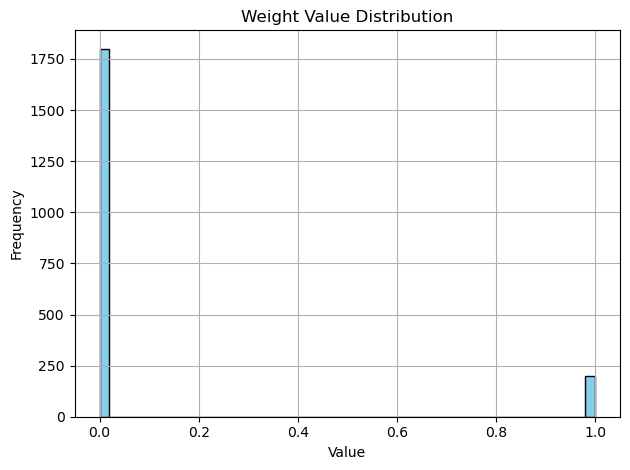

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

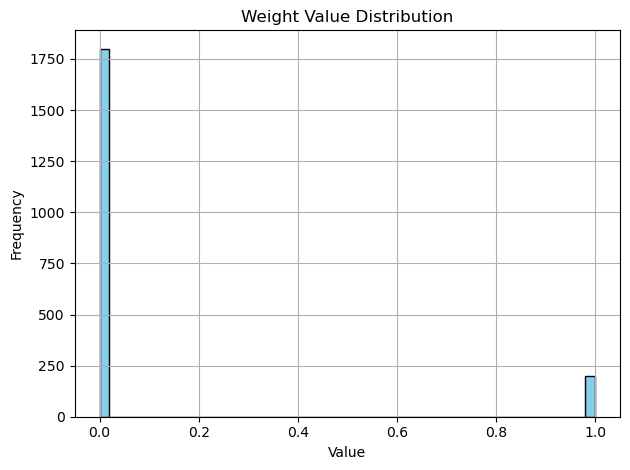

epoch-0   lr=['0.0001000'], tr/val_loss:  2.238577/  2.206429, val:  42.50%, val_best:  42.50%, tr:  35.88%, tr_best:  35.88%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0001000'], tr/val_loss:  2.172356/  2.161026, val:  52.08%, val_best:  52.08%, tr:  51.75%, tr_best:  51.75%
epoch-2   lr=['0.0001000'], tr/val_loss:  2.140097/  2.139443, val:  60.42%, val_best:  60.42%, tr:  59.27%, tr_best:  59.27%
epoch-3   lr=['0.0001000'], tr/val_loss:  2.122026/  2.122467, val:  55.83%, val_best:  60.42%, tr:  61.41%, tr_best:  61.41%
epoch-4   lr=['0.0001000'], tr/val_loss:  2.102640/  2.112667, val:  65.00%, val_best:  65.00%, tr:  63.38%, tr_best:  63.38%
epoch-5   lr=['0.0001000'], tr/val_loss:  2.092282/  2.099091, val:  55.83%, val_best:  65.00%, tr:  63.68%, tr_best:  63.68%
epoch-6   lr=['0.0001000'], tr/val_loss:  2.073615/  2.084144, val:  61.67%, val_best:  65.00%, tr:  64.54%, tr_best:  64.54%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▄▁▆▂▅▆█▅▆▂▃▅█▆▇▆▅▇▅▅▅█▅▅▄▇▅▅▆▆▇▇▅▅▅▂▅▆▆▅
max_val_scale_exp_8bit_1b,▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅████████████
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆█▆████████████████████
perc_999_scale_exp_8bit_1b,▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅████████████
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 3uprjxth with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path:

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250523_234018_592', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

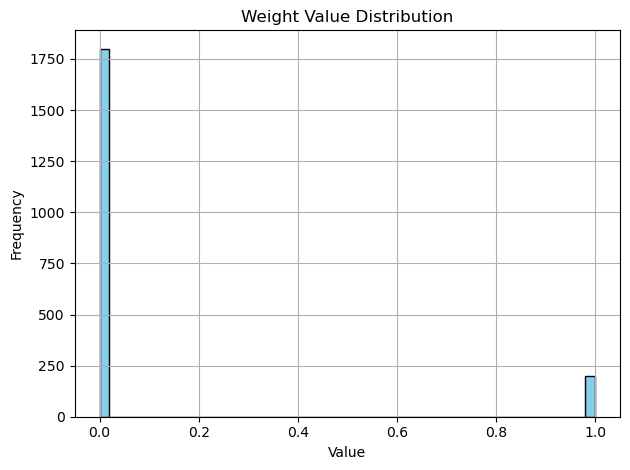

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

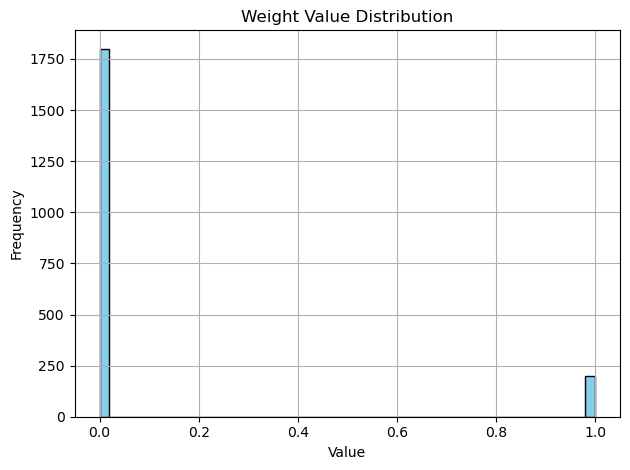

epoch-0   lr=['0.0001000'], tr/val_loss:  2.280934/  2.262200, val:  12.92%, val_best:  12.92%, tr:  13.32%, tr_best:  13.32%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0001000'], tr/val_loss:  2.232418/  2.232288, val:  23.33%, val_best:  23.33%, tr:  24.41%, tr_best:  24.41%
epoch-2   lr=['0.0001000'], tr/val_loss:  2.212512/  2.229920, val:  21.25%, val_best:  23.33%, tr:  28.34%, tr_best:  28.34%
epoch-3   lr=['0.0001000'], tr/val_loss:  2.208351/  2.220285, val:  25.00%, val_best:  25.00%, tr:  27.07%, tr_best:  28.34%
epoch-4   lr=['0.0001000'], tr/val_loss:  2.199544/  2.202841, val:  28.75%, val_best:  28.75%, tr:  26.11%, tr_best:  28.34%
epoch-5   lr=['0.0001000'], tr/val_loss:  2.180789/  2.186607, val:  32.50%, val_best:  32.50%, tr:  30.88%, tr_best:  30.88%
epoch-6   lr=['0.0001000'], tr/val_loss:  2.158707/  2.176503, val:  33.33%, val_best:  33.33%, tr:  37.52%, tr_best:  37.52%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
iter_acc,▃▁▁▂▁▂▃▂▃▆▆▅▆▄▆▅▃▅▃▆▇▃▄▃█▆▆▆▆▆▇▂▆▆▆▅▃▆█▇
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅████████████████
max_val_scale_exp_8bit_2b,▁███████████████████████████████████████
max_val_scale_exp_8bit_2w,▁███████████████████████████████████████
max_val_scale_exp_8bit_3b,▁███████████████████████████████████████
max_val_scale_exp_8bit_3w,▁▅▅▅▅▅▅▅▅▅▅█████████████████████████████
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁███████████████████████████████████████
perc_999_scale_exp_8bit_2b,▁███████████████████████████████████████


Run 3uprjxth errored:
Traceback (most recent call last):
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_30260/167908298.py", line 107, in hyper_iter
    my_snn_system(
  File "/tmp/ipykernel_30260/1543111053.py", line 720, in my_snn_system
    torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 380, in save
    return
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 214, in __exit__
    self.file_like.close()
OSError: [Errno 28] No space left on device

wandb: ERROR Run 3uprjxth errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
wandb: ERROR     self

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250523_235836_592', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

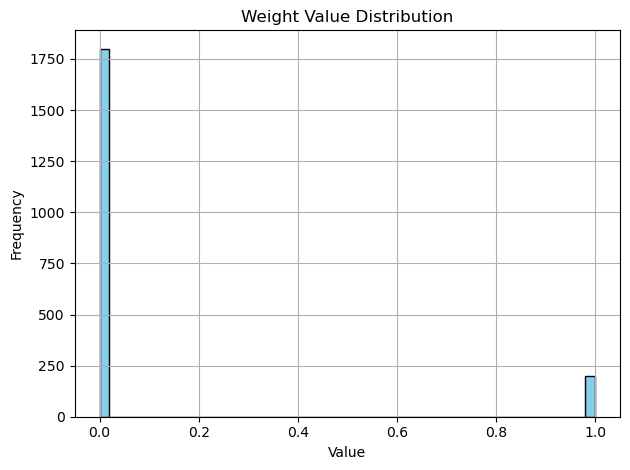

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

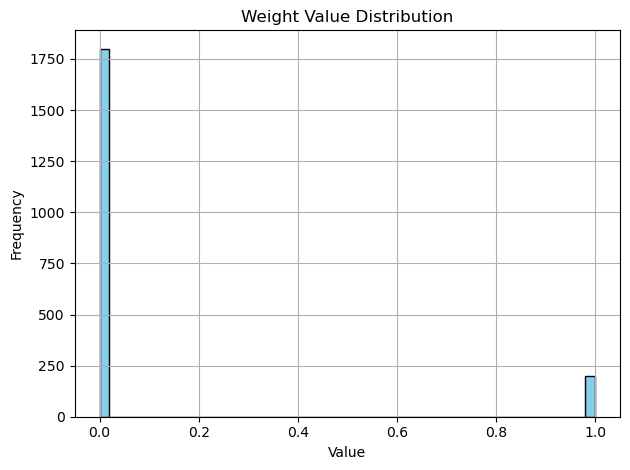

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iter_acc,▁▁▃▂▂▂▂▄▄▅▄▅▃▅▂▅▃▆▂▁▃▃▆▃▄▅▄▃▂▆█▇▅▆▆█▇▅▆▇
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Run vv6a2hrn errored:
Traceback (most recent call last):
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_30260/167908298.py", line 107, in hyper_iter
    my_snn_system(
  File "/tmp/ipykernel_30260/1543111053.py", line 720, in my_snn_system
    torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 380, in save
    return
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 214, in __exit__
    self.file_like.close()
OSError: [Errno 28] No space left on device

wandb: ERROR Run vv6a2hrn errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
wandb: ERROR     self

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_000059_299', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

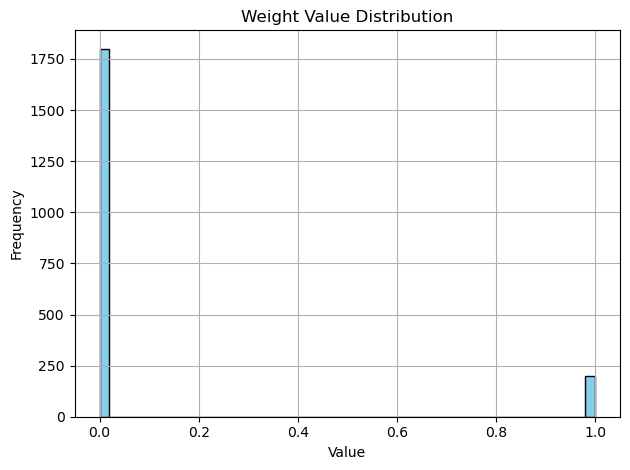

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

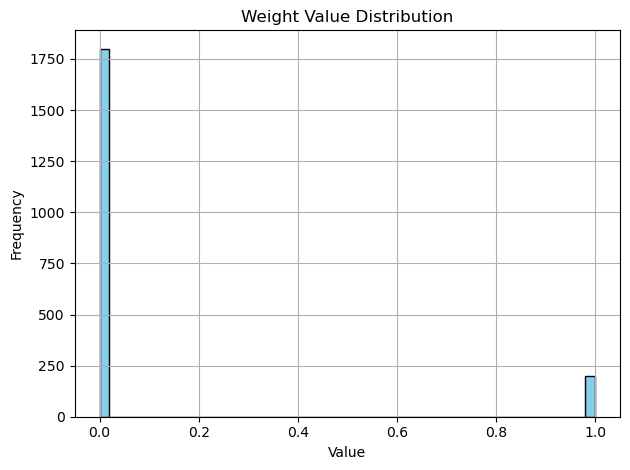

epoch-0   lr=['0.0100000'], tr/val_loss: 11.652016/  6.137368, val:  29.17%, val_best:  29.17%, tr:  30.21%, tr_best:  30.21%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
iter_acc,▃▂▄▂▄▆▃▄▄█▄▅▅▅▁▆▃▆▆▃▃▆▇▄▆▅▅█▄▆▃▇▃▅▃▁▇▄█▄
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████


Run 44hefjjz errored:
Traceback (most recent call last):
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_30260/167908298.py", line 107, in hyper_iter
    my_snn_system(
  File "/tmp/ipykernel_30260/1543111053.py", line 720, in my_snn_system
    torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 380, in save
    return
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 214, in __exit__
    self.file_like.close()
OSError: [Errno 28] No space left on device

wandb: ERROR Run 44hefjjz errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
wandb: ERROR     self

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_000958_445', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

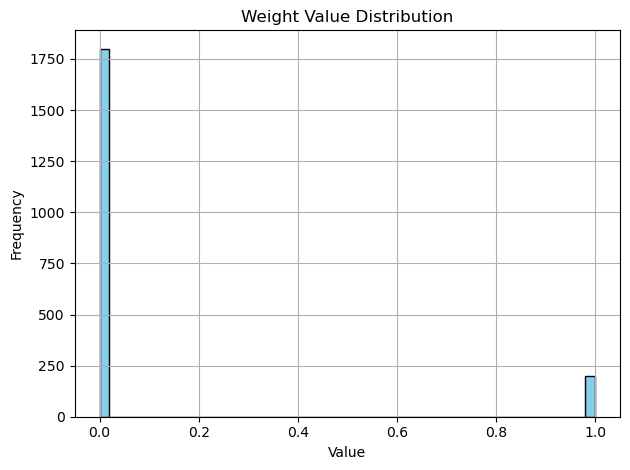

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

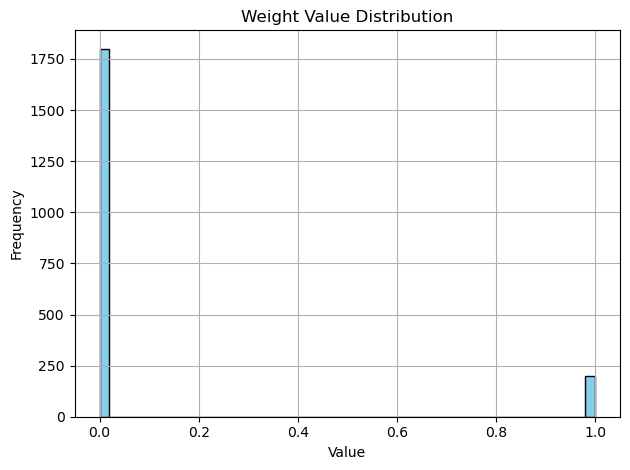

epoch-0   lr=['0.0100000'], tr/val_loss:  4.240242/  2.819689, val:  33.75%, val_best:  33.75%, tr:  28.34%, tr_best:  28.34%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  2.628670/  2.374351, val:  30.83%, val_best:  33.75%, tr:  36.73%, tr_best:  36.73%
epoch-2   lr=['0.0100000'], tr/val_loss:  2.138601/  2.078421, val:  45.83%, val_best:  45.83%, tr:  42.62%, tr_best:  42.62%
epoch-3   lr=['0.0100000'], tr/val_loss:  1.930071/  1.942134, val:  46.25%, val_best:  46.25%, tr:  47.00%, tr_best:  47.00%
epoch-4   lr=['0.0100000'], tr/val_loss:  1.819516/  1.939291, val:  40.42%, val_best:  46.25%, tr:  50.16%, tr_best:  50.16%
epoch-5   lr=['0.0100000'], tr/val_loss:  1.781956/  1.967048, val:  42.92%, val_best:  46.25%, tr:  51.43%, tr_best:  51.43%
epoch-6   lr=['0.0100000'], tr/val_loss:  1.719180/  2.115952, val:  41.67%, val_best:  46.25%, tr:  54.59%, tr_best:  54.59%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▂▂▃▂▄▅▃▄▅▅▆▅▇▄▇▄▅▇▅▆▇▇▄▆▆▃▅▇▆▅▅▅█▇▂▇▇▅▄
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁██████████████████████████████████████
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁██████████████████████████████████


wandb: Agent Starting Run: nlfhfb3h with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path:

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_010341_240', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

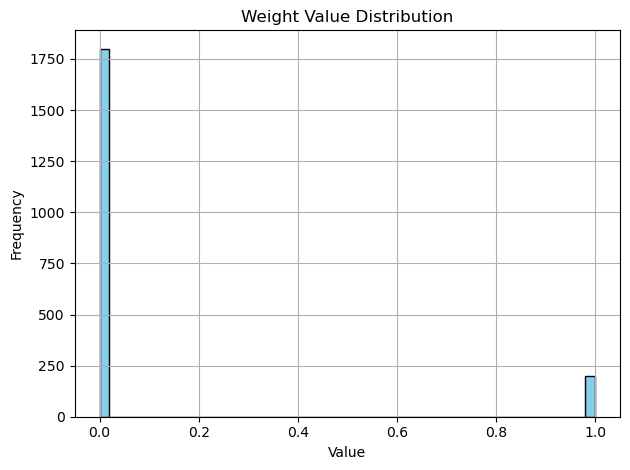

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

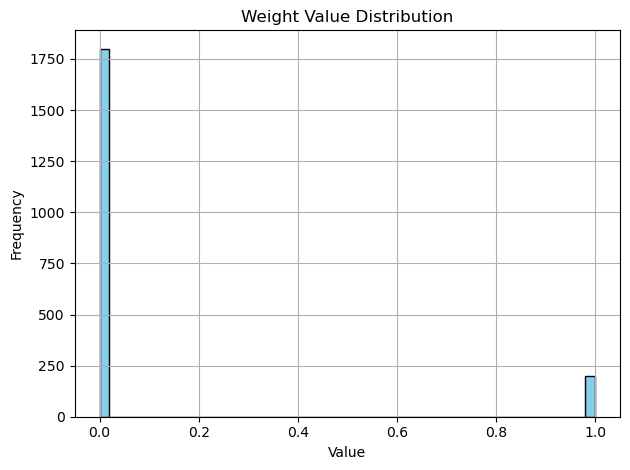

epoch-0   lr=['0.0001000'], tr/val_loss:  2.161547/  2.116442, val:  51.67%, val_best:  51.67%, tr:  46.46%, tr_best:  46.46%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0001000'], tr/val_loss:  2.102553/  2.120392, val:  50.42%, val_best:  51.67%, tr:  57.32%, tr_best:  57.32%
epoch-2   lr=['0.0001000'], tr/val_loss:  2.093991/  2.121588, val:  56.25%, val_best:  56.25%, tr:  58.55%, tr_best:  58.55%
epoch-3   lr=['0.0001000'], tr/val_loss:  2.101613/  2.133669, val:  59.17%, val_best:  59.17%, tr:  60.70%, tr_best:  60.70%
epoch-4   lr=['0.0001000'], tr/val_loss:  2.112144/  2.132517, val:  48.75%, val_best:  59.17%, tr:  61.43%, tr_best:  61.43%
epoch-5   lr=['0.0001000'], tr/val_loss:  2.120148/  2.142187, val:  56.25%, val_best:  59.17%, tr:  62.36%, tr_best:  62.36%
epoch-6   lr=['0.0001000'], tr/val_loss:  2.115178/  2.132096, val:  52.08%, val_best:  59.17%, tr:  61.66%, tr_best:  62.36%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▁▄▂▄▅▇▄▇▂▇▆▆▇▅▇▆▇▇▆▇▇▇▅▅▅▆▇▅▇█▇▅▇▅▃▇▇▇▇
max_val_scale_exp_8bit_1b,▁███████████████████████████████████████
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁██████████████████████████████████
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,██▁█████████████████████████████████████
perc_999_scale_exp_8bit_1b,▁███████▁███████████████████████████████
perc_999_scale_exp_8bit_1w,▁███████████████████████████████████████
perc_999_scale_exp_8bit_2b,▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅███▅█▅█████████▅███████


wandb: Agent Starting Run: 073wscta with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_015825_988', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

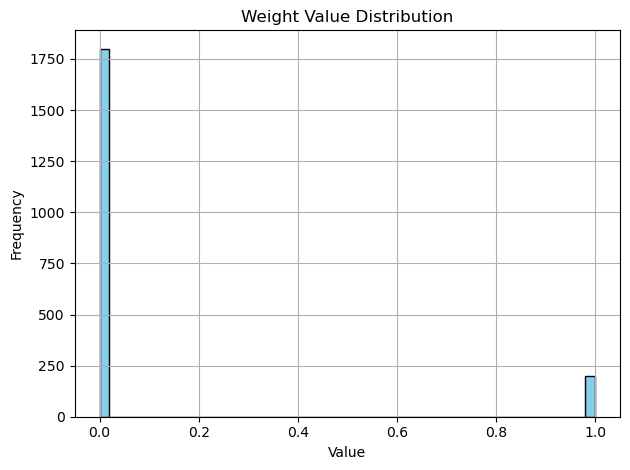

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

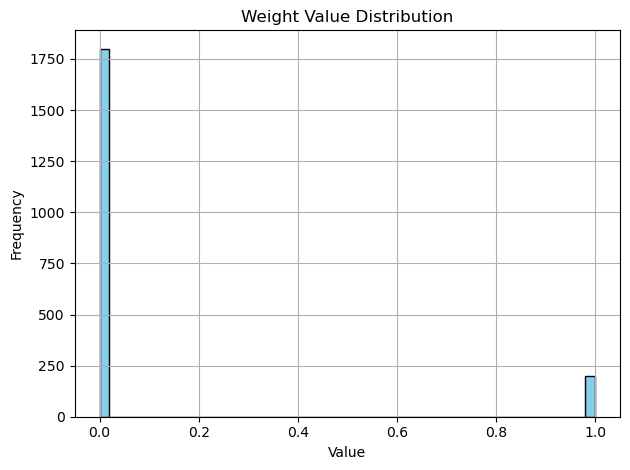

epoch-0   lr=['0.0100000'], tr/val_loss:  9.999474/  4.741576, val:  47.08%, val_best:  47.08%, tr:  33.09%, tr_best:  33.09%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  4.317998/  4.272262, val:  41.67%, val_best:  47.08%, tr:  44.79%, tr_best:  44.79%
epoch-2   lr=['0.0100000'], tr/val_loss:  3.587434/  2.395337, val:  46.67%, val_best:  47.08%, tr:  47.52%, tr_best:  47.52%
epoch-3   lr=['0.0100000'], tr/val_loss:  3.227541/  4.366070, val:  32.50%, val_best:  47.08%, tr:  48.16%, tr_best:  48.16%
epoch-4   lr=['0.0100000'], tr/val_loss:  3.165095/  4.180031, val:  40.00%, val_best:  47.08%, tr:  48.61%, tr_best:  48.61%
epoch-5   lr=['0.0100000'], tr/val_loss:  2.950414/  4.920671, val:  25.42%, val_best:  47.08%, tr:  49.88%, tr_best:  49.88%
epoch-6   lr=['0.0100000'], tr/val_loss:  2.784803/  4.235582, val:  30.83%, val_best:  47.08%, tr:  48.38%, tr_best:  49.88%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▄▃▃▅▆▃█▂▆▄▃▆█▅▃▆▃▃▃▁▇▇▆▃▅▃▅▄▅▃▃▃▅▄▆▃▅▃▅▃
max_val_scale_exp_8bit_1b,▁▁██████████████████████████████████████
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁██████████████████████████████████████
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ot61bdm8 with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: T

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_025327_614', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

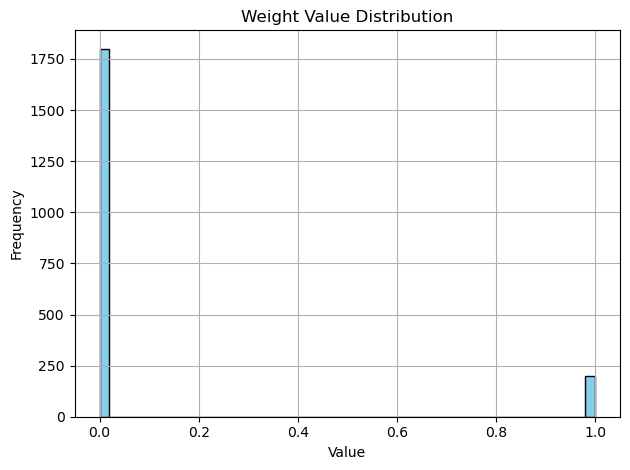

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

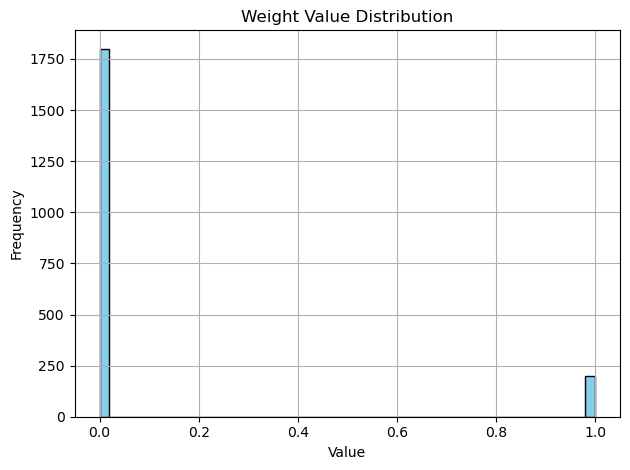

epoch-0   lr=['0.0100000'], tr/val_loss:  8.233433/  4.948097, val:  35.42%, val_best:  35.42%, tr:  30.95%, tr_best:  30.95%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  3.563427/  3.689555, val:  40.83%, val_best:  40.83%, tr:  42.82%, tr_best:  42.82%
epoch-2   lr=['0.0100000'], tr/val_loss:  2.482648/  2.236019, val:  51.25%, val_best:  51.25%, tr:  50.34%, tr_best:  50.34%
epoch-3   lr=['0.0100000'], tr/val_loss:  2.126007/  2.031570, val:  51.25%, val_best:  51.25%, tr:  50.68%, tr_best:  50.68%
epoch-4   lr=['0.0100000'], tr/val_loss:  1.855841/  2.029890, val:  40.00%, val_best:  51.25%, tr:  53.61%, tr_best:  53.61%
epoch-5   lr=['0.0100000'], tr/val_loss:  1.750209/  2.452225, val:  40.83%, val_best:  51.25%, tr:  54.71%, tr_best:  54.71%
epoch-6   lr=['0.0100000'], tr/val_loss:  1.658120/  2.442307, val:  45.42%, val_best:  51.25%, tr:  56.98%, tr_best:  56.98%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▂▃▃▄▃▄▃▅▃▁▅▃▆▆▄▃▆▆▃▆▅▇▅▃▃▆▆▅▆█▇▅▅▅▃▆▅▂▂
max_val_scale_exp_8bit_1b,▁▁██████████████████████████████████████
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁██████████████████████████████████████
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: qc5j8k1f with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_034829_919', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

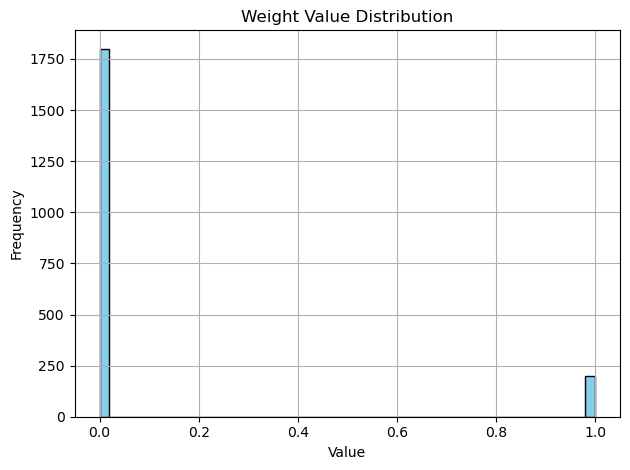

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

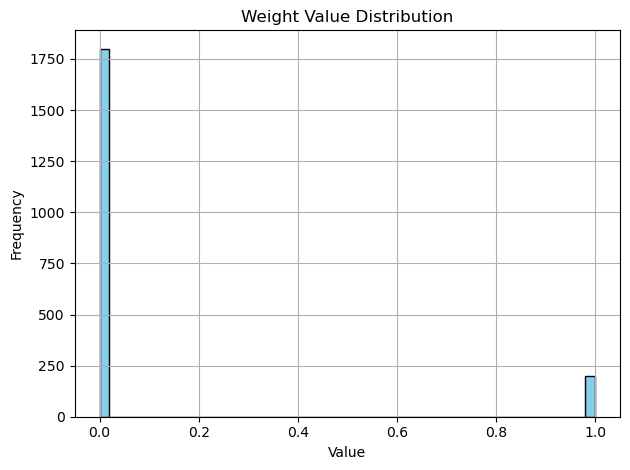

epoch-0   lr=['0.0100000'], tr/val_loss:  8.627133/  4.977457, val:  34.17%, val_best:  34.17%, tr:  25.87%, tr_best:  25.87%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  4.158969/  5.229832, val:  26.67%, val_best:  34.17%, tr:  30.77%, tr_best:  30.77%
epoch-2   lr=['0.0100000'], tr/val_loss:  3.569764/  3.088046, val:  35.42%, val_best:  35.42%, tr:  31.59%, tr_best:  31.59%
epoch-3   lr=['0.0100000'], tr/val_loss:  3.924863/  3.755249, val:  25.00%, val_best:  35.42%, tr:  31.02%, tr_best:  31.59%
epoch-4   lr=['0.0100000'], tr/val_loss:  3.476306/  4.828637, val:  20.83%, val_best:  35.42%, tr:  32.18%, tr_best:  32.18%
epoch-5   lr=['0.0100000'], tr/val_loss:  3.152553/  5.637908, val:  20.83%, val_best:  35.42%, tr:  31.36%, tr_best:  32.18%
epoch-6   lr=['0.0100000'], tr/val_loss:  3.222298/  2.354571, val:  32.08%, val_best:  35.42%, tr:  30.98%, tr_best:  32.18%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▅▂▂▅▂▃▆▃▂▄▁▆▅▅▃▄▄▄▄█▆▄▆▂▂▁▇▅█▂▁▄▅▂▂▃▇▆▄▅
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁███████████████████████████████████████


wandb: Agent Starting Run: kea7n9g7 with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path:

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_044322_796', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

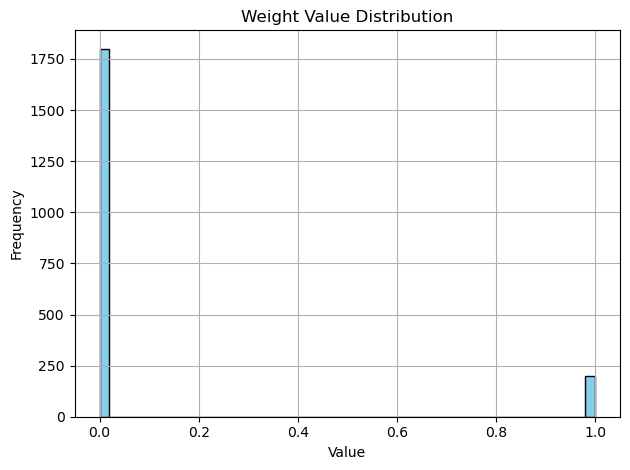

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

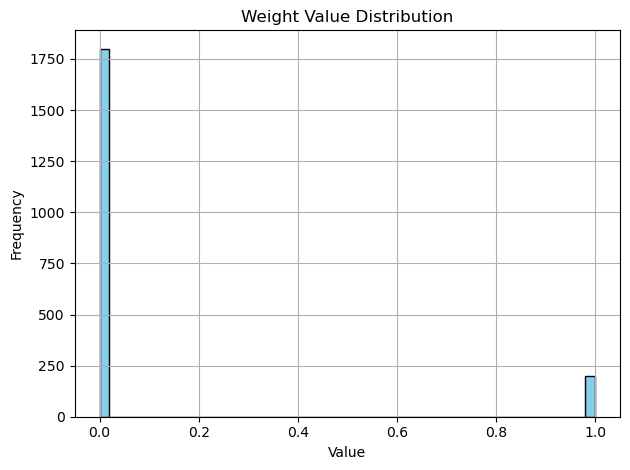

epoch-0   lr=['0.0001000'], tr/val_loss:  2.293393/  2.288391, val:  21.25%, val_best:  21.25%, tr:  16.04%, tr_best:  16.04%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0001000'], tr/val_loss:  2.285203/  2.281702, val:  14.17%, val_best:  21.25%, tr:  16.05%, tr_best:  16.05%
epoch-2   lr=['0.0001000'], tr/val_loss:  2.293826/  2.296749, val:   9.58%, val_best:  21.25%, tr:  11.77%, tr_best:  16.05%
epoch-3   lr=['0.0001000'], tr/val_loss:  2.312561/  2.320265, val:   1.67%, val_best:  21.25%, tr:   7.84%, tr_best:  16.05%
epoch-4   lr=['0.0001000'], tr/val_loss:  2.326148/  2.334581, val:   2.50%, val_best:  21.25%, tr:   6.09%, tr_best:  16.05%
epoch-5   lr=['0.0001000'], tr/val_loss:  2.331621/  2.344155, val:   3.33%, val_best:  21.25%, tr:   5.52%, tr_best:  16.05%
epoch-6   lr=['0.0001000'], tr/val_loss:  2.335703/  2.342685, val:   6.25%, val_best:  21.25%, tr:   6.82%, tr_best:  16.05%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,█▁▁█▃▁▃▃▁▃▃▁▆▁▁▁▁▃▁▃▁▁▆▃▁▁▃▃▁▅▅▃▁▆▅▃▅▅▃▃
max_val_scale_exp_8bit_1b,▁▅▅▅▅▅▅▅████████████████████████████████
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁██████████████████████████████████████
perc_999_scale_exp_8bit_1b,▁▅▅▅▅▅▅▅████████████████████████████████
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: c5li7cgw with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path:

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_053820_056', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

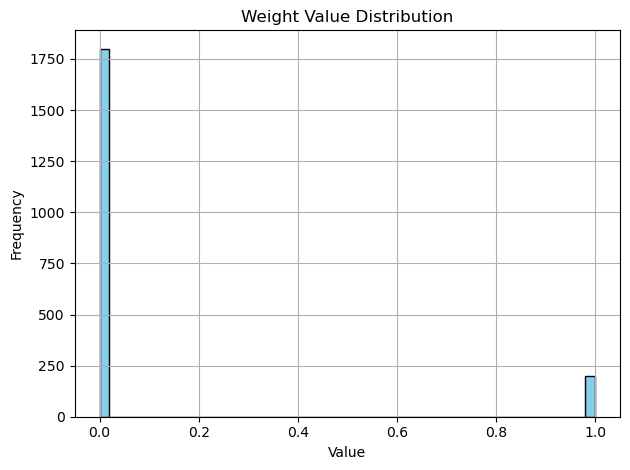

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

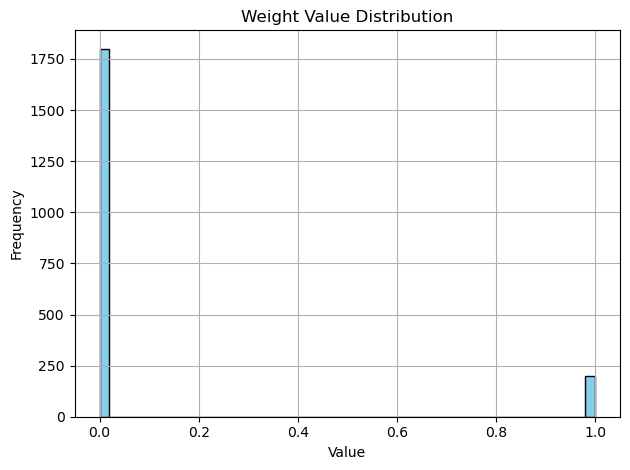

epoch-0   lr=['0.0001000'], tr/val_loss:  2.204466/  2.145771, val:  43.33%, val_best:  43.33%, tr:  34.41%, tr_best:  34.41%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0001000'], tr/val_loss:  2.111438/  2.106745, val:  49.17%, val_best:  49.17%, tr:  51.91%, tr_best:  51.91%
epoch-2   lr=['0.0001000'], tr/val_loss:  2.071045/  2.093524, val:  55.42%, val_best:  55.42%, tr:  54.66%, tr_best:  54.66%
epoch-3   lr=['0.0001000'], tr/val_loss:  2.071124/  2.107572, val:  53.33%, val_best:  55.42%, tr:  55.86%, tr_best:  55.86%
epoch-4   lr=['0.0001000'], tr/val_loss:  2.064967/  2.091131, val:  45.83%, val_best:  55.42%, tr:  56.70%, tr_best:  56.70%
epoch-5   lr=['0.0001000'], tr/val_loss:  2.056717/  2.075104, val:  46.25%, val_best:  55.42%, tr:  58.95%, tr_best:  58.95%
epoch-6   lr=['0.0001000'], tr/val_loss:  2.032712/  2.052747, val:  59.17%, val_best:  59.17%, tr:  59.29%, tr_best:  59.29%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▅▂▅▁▃▄▇▆▆▇▄█▅▅▅▆▃▅▇▅█▅█▃▄█▆▇▇▇▇▇▅▆▇███▇▆
max_val_scale_exp_8bit_1b,▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█▅█▅██████▅██████████████
max_val_scale_exp_8bit_1w,▁▁▁█████████████████████████████████████
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█████████▁▁▁██
perc_999_scale_exp_8bit_1b,▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████▅▅▅████████████
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁███
perc_999_scale_exp_8bit_2b,▁▁▁█████████████████████████████████████


wandb: Agent Starting Run: p1q03bxn with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path:

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_063305_040', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

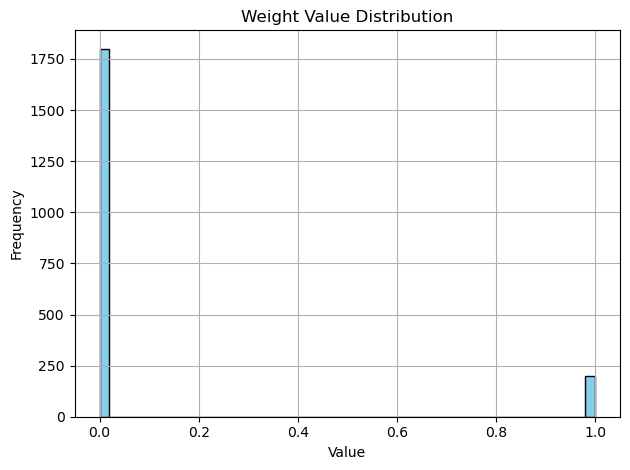

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

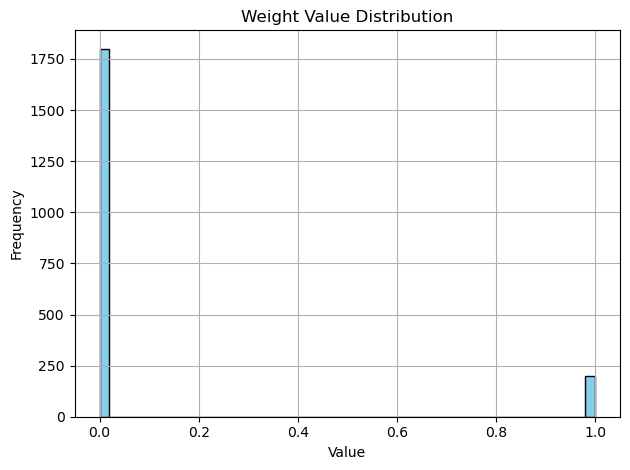

epoch-0   lr=['0.0001000'], tr/val_loss:  2.260388/  2.242423, val:  29.58%, val_best:  29.58%, tr:  28.46%, tr_best:  28.46%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0001000'], tr/val_loss:  2.218749/  2.212923, val:  38.75%, val_best:  38.75%, tr:  38.00%, tr_best:  38.00%
epoch-2   lr=['0.0001000'], tr/val_loss:  2.188848/  2.193048, val:  43.75%, val_best:  43.75%, tr:  41.93%, tr_best:  41.93%
epoch-3   lr=['0.0001000'], tr/val_loss:  2.173747/  2.174851, val:  44.58%, val_best:  44.58%, tr:  42.61%, tr_best:  42.61%
epoch-4   lr=['0.0001000'], tr/val_loss:  2.159181/  2.161634, val:  49.58%, val_best:  49.58%, tr:  43.77%, tr_best:  43.77%
epoch-5   lr=['0.0001000'], tr/val_loss:  2.143389/  2.140365, val:  47.50%, val_best:  49.58%, tr:  50.25%, tr_best:  50.25%
epoch-6   lr=['0.0001000'], tr/val_loss:  2.114884/  2.124108, val:  52.50%, val_best:  52.50%, tr:  54.66%, tr_best:  54.66%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▃▁▃▁▄▆▇▅▆▅▆█▆▆▅▇▆▅▅▅▃▆▅▆▅▃▃▇▄▄▄▆▆▆▆▆▄▆▅▅
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁█████████████████████████████████
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁███████████████████████████████████████
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁█████████████████████████████████
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: rueqnjm5 with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_072759_492', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

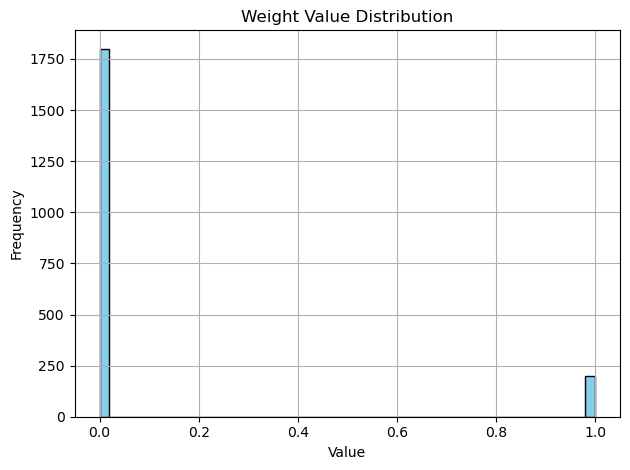

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

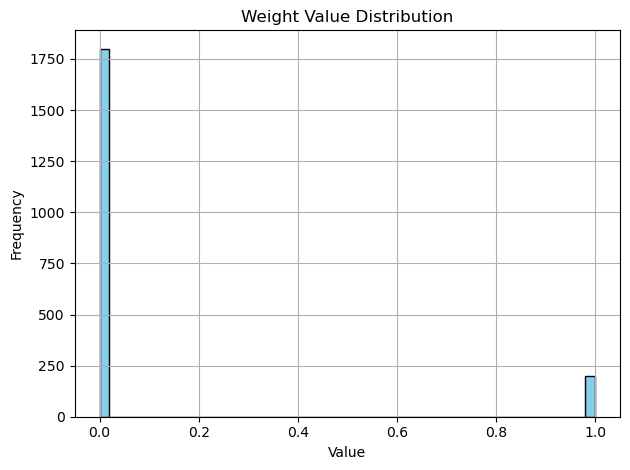

epoch-0   lr=['0.0100000'], tr/val_loss:  8.427676/  7.114044, val:  28.75%, val_best:  28.75%, tr:  30.45%, tr_best:  30.45%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  4.461568/  3.242999, val:  36.25%, val_best:  36.25%, tr:  38.32%, tr_best:  38.32%
epoch-2   lr=['0.0100000'], tr/val_loss:  3.297950/  4.088671, val:  46.25%, val_best:  46.25%, tr:  43.20%, tr_best:  43.20%
epoch-3   lr=['0.0100000'], tr/val_loss:  2.958849/  1.776453, val:  41.25%, val_best:  46.25%, tr:  44.54%, tr_best:  44.54%
epoch-4   lr=['0.0100000'], tr/val_loss:  2.739897/  3.552567, val:  30.42%, val_best:  46.25%, tr:  45.23%, tr_best:  45.23%
epoch-5   lr=['0.0100000'], tr/val_loss:  2.819782/  3.456177, val:  32.92%, val_best:  46.25%, tr:  44.45%, tr_best:  45.23%
epoch-6   lr=['0.0100000'], tr/val_loss:  2.731582/  4.243082, val:  22.92%, val_best:  46.25%, tr:  44.14%, tr_best:  45.23%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▄▅▅▄▅▅▆▅▅▄▂▇▅█▄█▁▅▅▅▆▇▅▅▅▁▆▇▇▆▆▅▅▃▅▂▅▄▅▄
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁██████████████████████████████████████
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁████████████████████████████████████


wandb: Agent Starting Run: sjw0jyku with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path:

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_082239_483', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

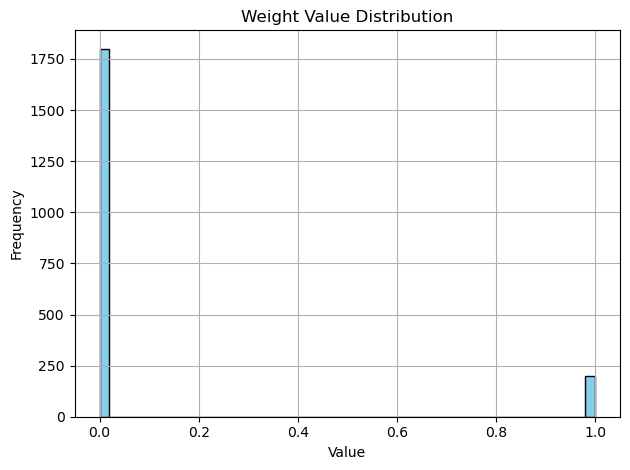

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

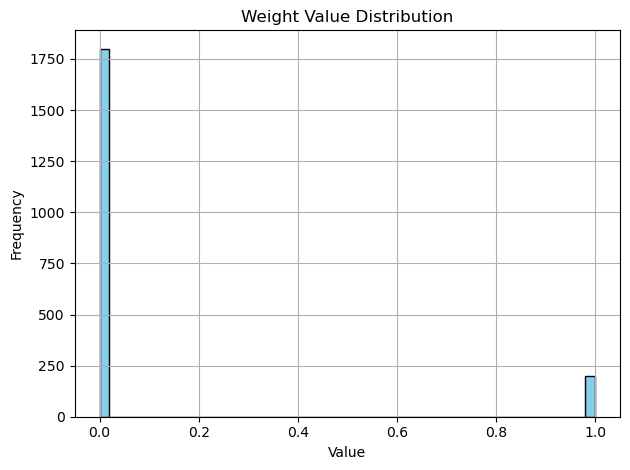

epoch-0   lr=['0.0001000'], tr/val_loss:  2.213324/  2.187509, val:  46.25%, val_best:  46.25%, tr:  39.64%, tr_best:  39.64%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0001000'], tr/val_loss:  2.170873/  2.183819, val:  43.75%, val_best:  46.25%, tr:  51.70%, tr_best:  51.70%
epoch-2   lr=['0.0001000'], tr/val_loss:  2.180164/  2.199740, val:  54.17%, val_best:  54.17%, tr:  55.82%, tr_best:  55.82%
epoch-3   lr=['0.0001000'], tr/val_loss:  2.183416/  2.201701, val:  52.50%, val_best:  54.17%, tr:  55.86%, tr_best:  55.86%
epoch-4   lr=['0.0001000'], tr/val_loss:  2.188128/  2.198908, val:  52.92%, val_best:  54.17%, tr:  56.39%, tr_best:  56.39%
epoch-5   lr=['0.0001000'], tr/val_loss:  2.188859/  2.201178, val:  50.83%, val_best:  54.17%, tr:  57.29%, tr_best:  57.29%
epoch-6   lr=['0.0001000'], tr/val_loss:  2.192088/  2.206852, val:  53.33%, val_best:  54.17%, tr:  58.04%, tr_best:  58.04%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▄▁▅▄▅▅▆▅▅▄▅▆▅▄▇▅▅▅█▅▇▇▅▅▄▄▇▅▇▄▇▅▆▂▅▄▆▄▄▆
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁█████████████████████████████████████
max_val_scale_exp_8bit_2b,▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████████
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,████▁███████████████████████████████████
perc_999_scale_exp_8bit_1b,▁███████████████████████████████████████
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█████████████████████
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████████████████████


wandb: Agent Starting Run: 79h2l6ef with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_091730_896', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

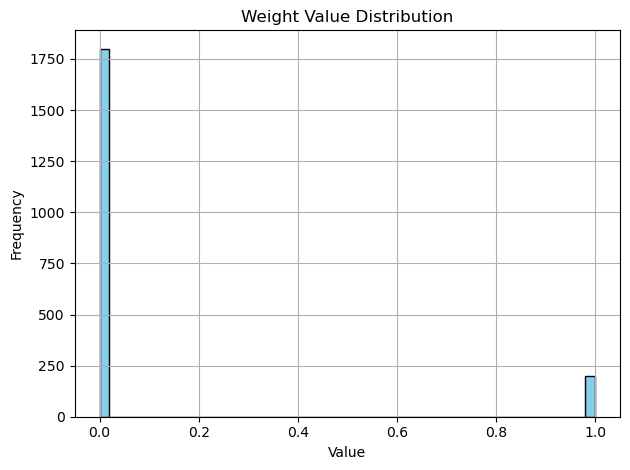

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

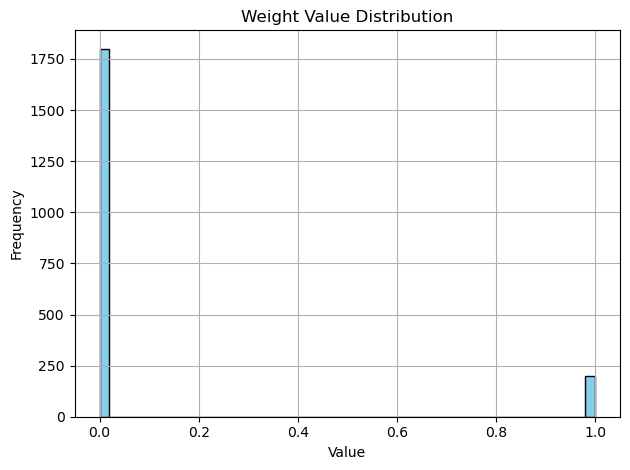

epoch-0   lr=['0.0100000'], tr/val_loss: 13.819495/  5.258099, val:  47.50%, val_best:  47.50%, tr:  33.91%, tr_best:  33.91%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  3.614824/  2.684216, val:  47.08%, val_best:  47.50%, tr:  48.57%, tr_best:  48.57%
epoch-2   lr=['0.0100000'], tr/val_loss:  2.331008/  1.739619, val:  55.00%, val_best:  55.00%, tr:  53.48%, tr_best:  53.48%
epoch-3   lr=['0.0100000'], tr/val_loss:  1.748822/  1.890516, val:  47.92%, val_best:  55.00%, tr:  54.80%, tr_best:  54.80%
epoch-4   lr=['0.0100000'], tr/val_loss:  1.533618/  1.539059, val:  55.00%, val_best:  55.00%, tr:  54.68%, tr_best:  54.80%
epoch-5   lr=['0.0100000'], tr/val_loss:  1.503985/  2.146652, val:  37.92%, val_best:  55.00%, tr:  52.77%, tr_best:  54.80%
epoch-6   lr=['0.0100000'], tr/val_loss:  1.451315/  1.705667, val:  47.92%, val_best:  55.00%, tr:  53.29%, tr_best:  54.80%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▄▄▆▃▄▅▇▃▃▄▃▃▃█▄▅▃▂▆▃▅▇▅▅▅▅▆▅▆▅▄▁▆▃▆▂▄▄▃▅
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 5itvwwhl with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path:

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_101215_895', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

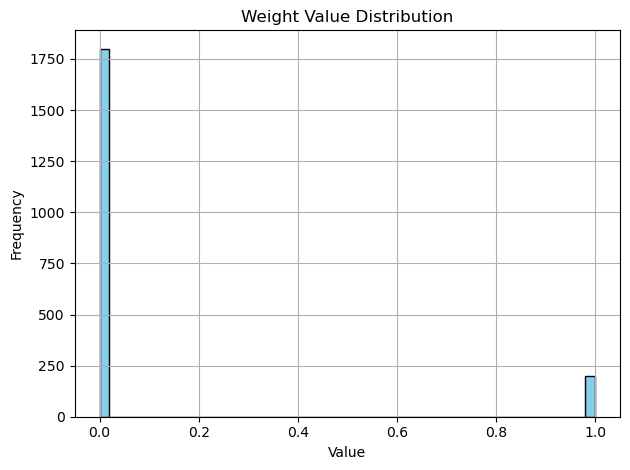

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

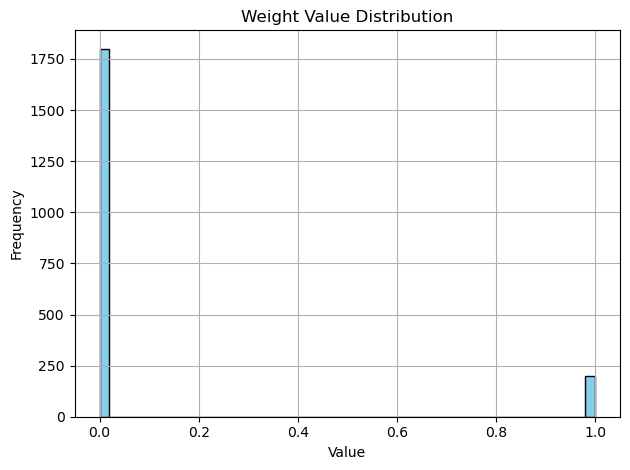

epoch-0   lr=['0.0001000'], tr/val_loss:  2.210321/  2.150491, val:  52.08%, val_best:  52.08%, tr:  36.64%, tr_best:  36.64%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0001000'], tr/val_loss:  2.123761/  2.140806, val:  44.17%, val_best:  52.08%, tr:  52.54%, tr_best:  52.54%
epoch-2   lr=['0.0001000'], tr/val_loss:  2.121270/  2.133173, val:  59.58%, val_best:  59.58%, tr:  54.43%, tr_best:  54.43%
epoch-3   lr=['0.0001000'], tr/val_loss:  2.119465/  2.139703, val:  51.25%, val_best:  59.58%, tr:  55.25%, tr_best:  55.25%
epoch-4   lr=['0.0001000'], tr/val_loss:  2.119272/  2.126843, val:  48.33%, val_best:  59.58%, tr:  54.20%, tr_best:  55.25%
epoch-5   lr=['0.0001000'], tr/val_loss:  2.117169/  2.132483, val:  47.50%, val_best:  59.58%, tr:  55.50%, tr_best:  55.50%
epoch-6   lr=['0.0001000'], tr/val_loss:  2.117110/  2.134445, val:  48.33%, val_best:  59.58%, tr:  56.52%, tr_best:  56.52%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▃▁▆▃▅▆▃▅▄▃▃▆▆▇▆█▆█▆▁▇▆▆▆▃▂▆▃▆▄█▃▆▁▃▂▆▅▃▆
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▅▅▅▅▅▅▅▅▅▅█▅██▅▅▅██▅▅████████▅████████
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▃▆▆▆█████████████████████████████████
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▅▅▅▅▅▅▅▅▅▅▅███████████████████████████
perc_999_scale_exp_8bit_2b,▁▁██████████████████████████████████████


wandb: Agent Starting Run: faqdn6jd with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_110658_046', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

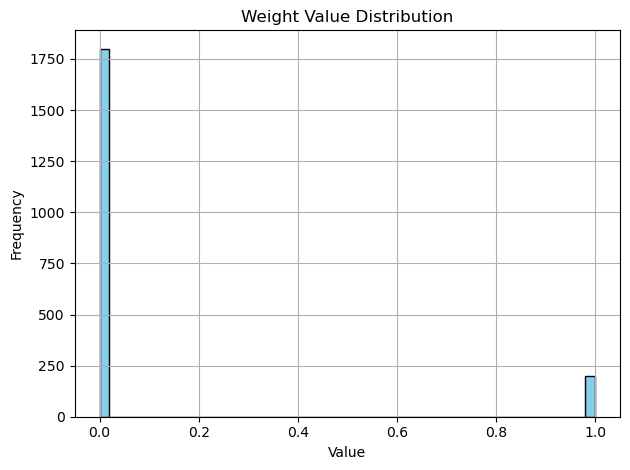

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

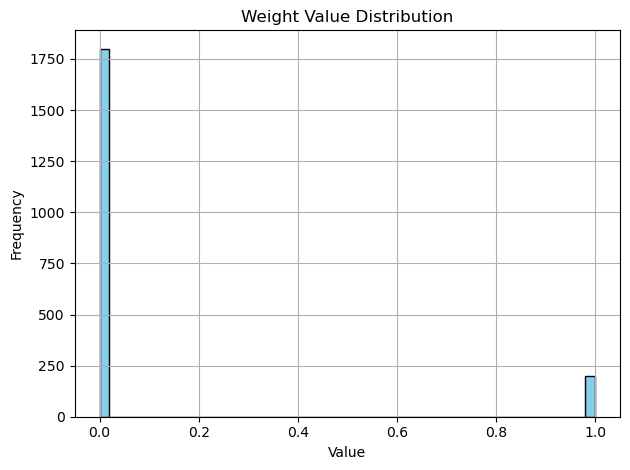

epoch-0   lr=['0.0100000'], tr/val_loss:  4.972353/  2.031694, val:  41.67%, val_best:  41.67%, tr:  25.43%, tr_best:  25.43%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  2.505837/  2.059868, val:  38.33%, val_best:  41.67%, tr:  27.14%, tr_best:  27.14%
epoch-2   lr=['0.0100000'], tr/val_loss:  2.247940/  2.002273, val:  27.92%, val_best:  41.67%, tr:  29.52%, tr_best:  29.52%
epoch-3   lr=['0.0100000'], tr/val_loss:  2.226516/  2.135296, val:  28.75%, val_best:  41.67%, tr:  30.05%, tr_best:  30.05%
epoch-4   lr=['0.0100000'], tr/val_loss:  2.221536/  2.315133, val:  28.33%, val_best:  41.67%, tr:  29.25%, tr_best:  30.05%
epoch-5   lr=['0.0100000'], tr/val_loss:  2.251055/  2.536733, val:  28.75%, val_best:  41.67%, tr:  27.09%, tr_best:  30.05%
epoch-6   lr=['0.0100000'], tr/val_loss:  2.222794/  2.227817, val:  24.58%, val_best:  41.67%, tr:  27.20%, tr_best:  30.05%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▅▄▃▄▂▃▃▁▅▁▃▁▂▁▃▆▄▁▇▇▆▅▃▆▁█▂▁▂▃▆▃▂▇▇▇▃▅▂
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: obamfaxw with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_120139_422', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

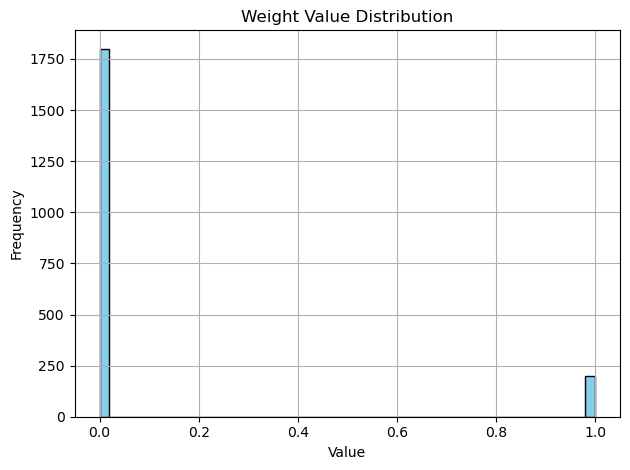

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

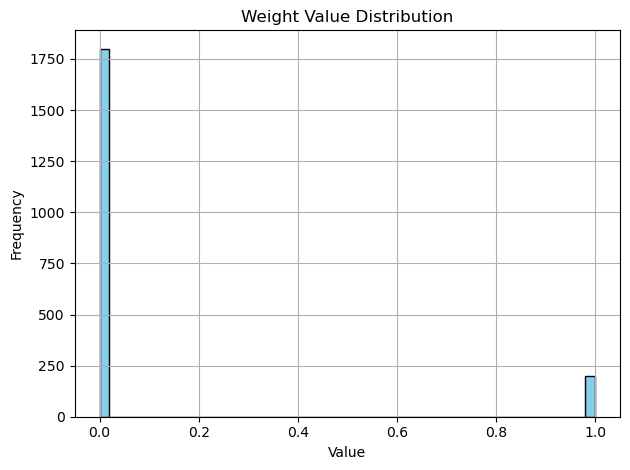

epoch-0   lr=['0.0100000'], tr/val_loss: 12.440171/  3.955144, val:  40.42%, val_best:  40.42%, tr:  31.00%, tr_best:  31.00%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  3.011925/  2.518583, val:  32.50%, val_best:  40.42%, tr:  35.34%, tr_best:  35.34%
epoch-2   lr=['0.0100000'], tr/val_loss:  2.726816/  2.301401, val:  34.17%, val_best:  40.42%, tr:  36.55%, tr_best:  36.55%
epoch-3   lr=['0.0100000'], tr/val_loss:  2.169980/  1.826662, val:  39.58%, val_best:  40.42%, tr:  35.64%, tr_best:  36.55%
epoch-4   lr=['0.0100000'], tr/val_loss:  1.996110/  2.317657, val:  24.58%, val_best:  40.42%, tr:  35.38%, tr_best:  36.55%
epoch-5   lr=['0.0100000'], tr/val_loss:  1.964058/  1.899410, val:  37.08%, val_best:  40.42%, tr:  34.32%, tr_best:  36.55%
epoch-6   lr=['0.0100000'], tr/val_loss:  2.025183/  1.893651, val:  35.83%, val_best:  40.42%, tr:  33.52%, tr_best:  36.55%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▃▇▆▂▆▂▆▅▁▄▄▇▇▄▄▃▂▅█▇▁▆▅▄▁▁▁▆▇▂▂▄▂▃▇▁▆▁▃▃
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: xlnhr10o with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_125617_232', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

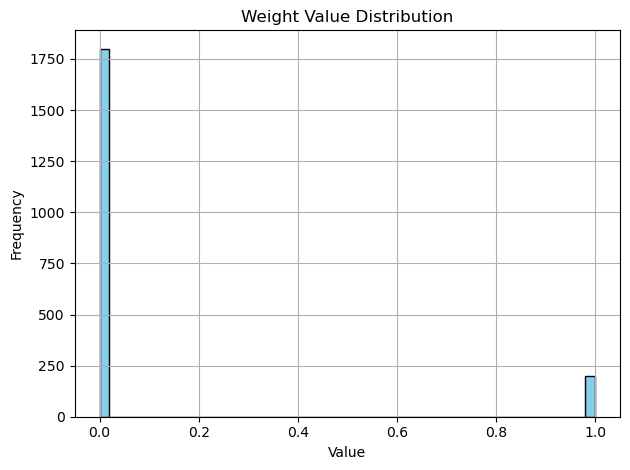

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

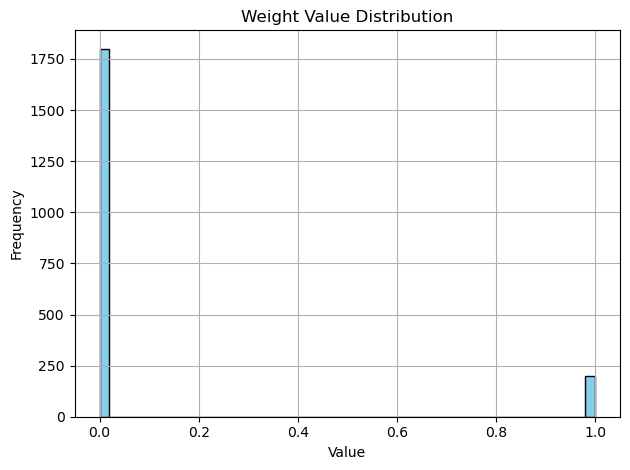

epoch-0   lr=['0.0100000'], tr/val_loss: 10.926411/  6.782095, val:  36.25%, val_best:  36.25%, tr:  31.71%, tr_best:  31.71%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  5.040632/  5.449863, val:  39.17%, val_best:  39.17%, tr:  40.77%, tr_best:  40.77%
epoch-2   lr=['0.0100000'], tr/val_loss:  3.898542/  3.150926, val:  41.67%, val_best:  41.67%, tr:  45.70%, tr_best:  45.70%
epoch-3   lr=['0.0100000'], tr/val_loss:  3.701163/  4.693992, val:  41.25%, val_best:  41.67%, tr:  46.27%, tr_best:  46.27%
epoch-4   lr=['0.0100000'], tr/val_loss:  3.674828/  3.472392, val:  40.83%, val_best:  41.67%, tr:  45.48%, tr_best:  46.27%
epoch-5   lr=['0.0100000'], tr/val_loss:  3.385710/  4.275244, val:  33.75%, val_best:  41.67%, tr:  46.59%, tr_best:  46.59%
epoch-6   lr=['0.0100000'], tr/val_loss:  3.335268/  3.937685, val:  37.50%, val_best:  41.67%, tr:  46.91%, tr_best:  46.91%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▃▂▂▃▅▃█▃▅▁▃▆▅▆▄▅▁▄█▃▇▃▅▅▅▂▇▃▅▅▂▃▅▂▅▂▅▂▆▂
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▅▅█████████████████████████████████████
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅█▅██▅▅▅▅▅▅█


wandb: Agent Starting Run: paq7889r with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path:

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_135052_390', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

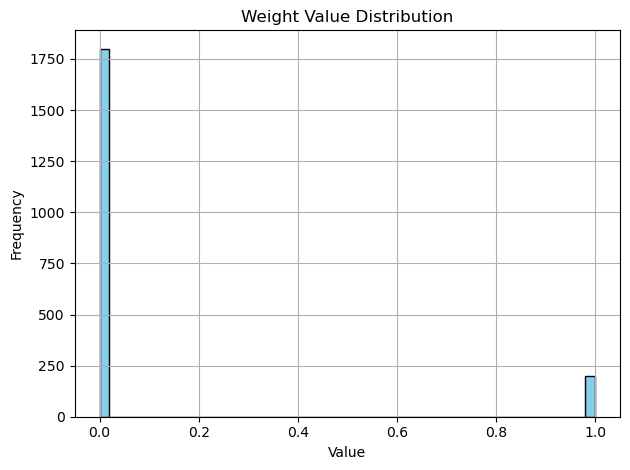

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

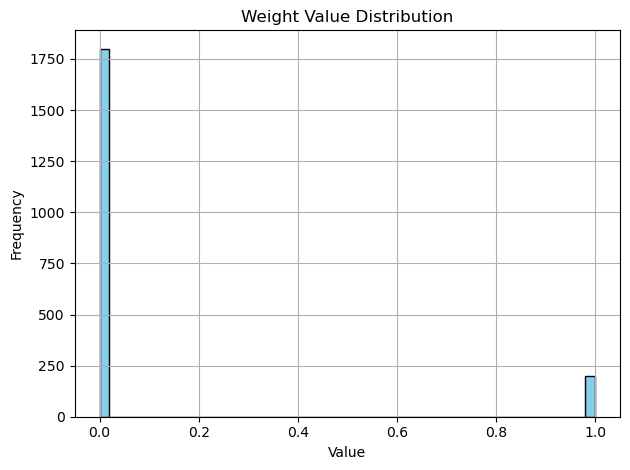

epoch-0   lr=['0.0001000'], tr/val_loss:  2.317511/  2.326627, val:  12.08%, val_best:  12.08%, tr:  13.25%, tr_best:  13.25%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0001000'], tr/val_loss:  2.314142/  2.311154, val:  12.50%, val_best:  12.50%, tr:  15.86%, tr_best:  15.86%
epoch-2   lr=['0.0001000'], tr/val_loss:  2.301179/  2.302863, val:  13.75%, val_best:  13.75%, tr:  17.00%, tr_best:  17.00%
epoch-3   lr=['0.0001000'], tr/val_loss:  2.295858/  2.307151, val:  12.50%, val_best:  13.75%, tr:  18.29%, tr_best:  18.29%
epoch-4   lr=['0.0001000'], tr/val_loss:  2.301318/  2.307250, val:  10.83%, val_best:  13.75%, tr:  13.79%, tr_best:  18.29%
epoch-5   lr=['0.0001000'], tr/val_loss:  2.297880/  2.308104, val:  10.83%, val_best:  13.75%, tr:  14.43%, tr_best:  18.29%
epoch-6   lr=['0.0001000'], tr/val_loss:  2.300480/  2.310312, val:  10.42%, val_best:  13.75%, tr:  14.02%, tr_best:  18.29%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,█▅▁▃▄▅▄▄▆▂▅▃▃▂▆▃▄▇▅▂▂▅▄▄▅▅▅▆▂▃▄▇▄▄▂▆▆▅▄▅
max_val_scale_exp_8bit_1b,▁███████████████████████████████████████
max_val_scale_exp_8bit_1w,▁▁▁▅▅▅▅▅▅▅▅▅▅█▅██▅█████████▅█▅▅▅█▅▅█▅██▅
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁███████████████████████████████████████
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 6n38bslt with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_144028_423', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

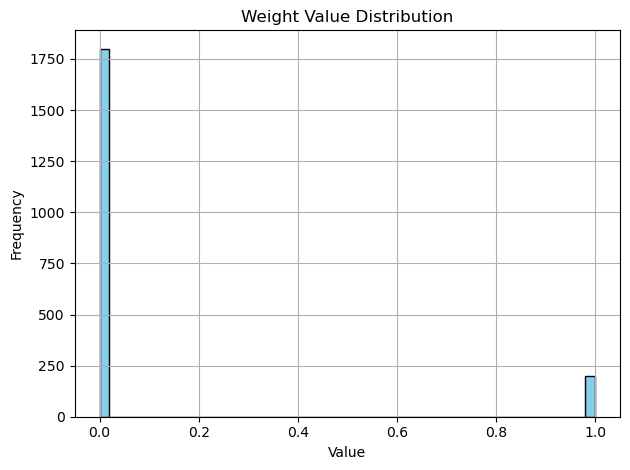

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

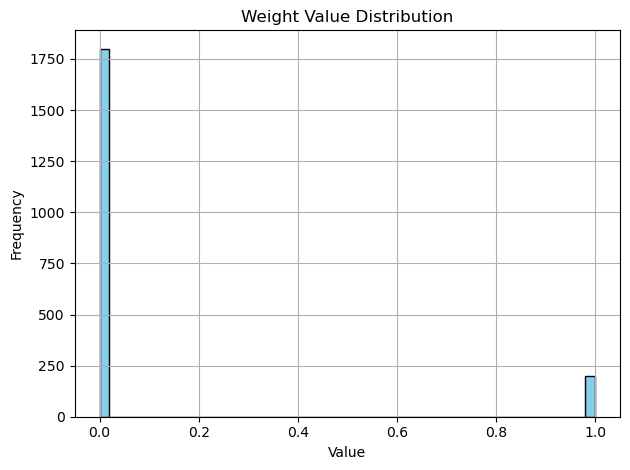

epoch-0   lr=['0.0100000'], tr/val_loss:  5.130701/  2.790810, val:  41.67%, val_best:  41.67%, tr:  29.05%, tr_best:  29.05%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  2.786133/  2.785457, val:  39.17%, val_best:  41.67%, tr:  39.57%, tr_best:  39.57%
epoch-2   lr=['0.0100000'], tr/val_loss:  2.267152/  1.905344, val:  48.33%, val_best:  48.33%, tr:  44.98%, tr_best:  44.98%
epoch-3   lr=['0.0100000'], tr/val_loss:  2.029374/  1.843377, val:  49.17%, val_best:  49.17%, tr:  46.32%, tr_best:  46.32%
epoch-4   lr=['0.0100000'], tr/val_loss:  1.968996/  2.203148, val:  40.00%, val_best:  49.17%, tr:  48.86%, tr_best:  48.86%
epoch-5   lr=['0.0100000'], tr/val_loss:  1.883028/  1.701428, val:  41.25%, val_best:  49.17%, tr:  50.04%, tr_best:  50.04%
epoch-6   lr=['0.0100000'], tr/val_loss:  1.782254/  2.350710, val:  47.50%, val_best:  49.17%, tr:  52.98%, tr_best:  52.98%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▃▄▃▇▄█▄▄▅▅█▅█▄▅▃▅▇▅▇▆▇▄▄▄▇▅▅▇▅▅█▄▆▃▅▅▅▅
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁███████████████████████████████████████
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: bl4bt1v7 with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_152809_266', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

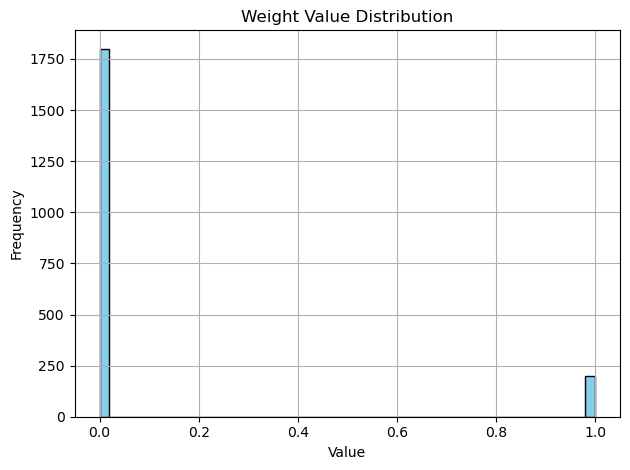

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

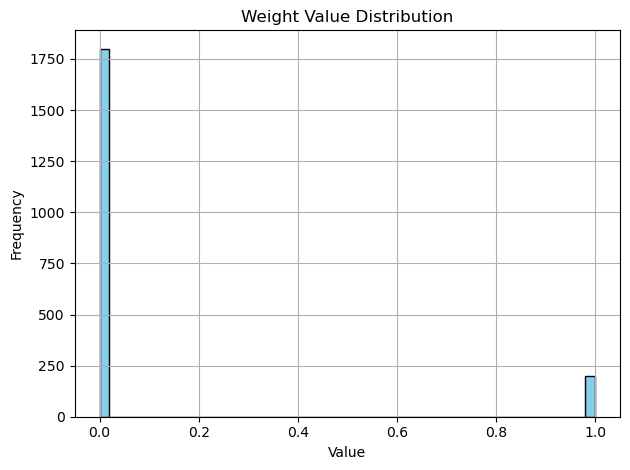

epoch-0   lr=['0.0100000'], tr/val_loss: 12.066037/  5.682862, val:  44.58%, val_best:  44.58%, tr:  30.89%, tr_best:  30.89%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  4.645714/  3.786308, val:  39.58%, val_best:  44.58%, tr:  42.84%, tr_best:  42.84%
epoch-2   lr=['0.0100000'], tr/val_loss:  3.733496/  3.136752, val:  53.75%, val_best:  53.75%, tr:  45.79%, tr_best:  45.79%
epoch-3   lr=['0.0100000'], tr/val_loss:  3.376370/  2.188410, val:  42.50%, val_best:  53.75%, tr:  45.12%, tr_best:  45.79%
epoch-4   lr=['0.0100000'], tr/val_loss:  3.036463/  4.828130, val:  35.42%, val_best:  53.75%, tr:  44.05%, tr_best:  45.79%
epoch-5   lr=['0.0100000'], tr/val_loss:  2.583281/  3.439054, val:  31.67%, val_best:  53.75%, tr:  44.73%, tr_best:  45.79%
epoch-6   lr=['0.0100000'], tr/val_loss:  2.297679/  3.233353, val:  30.00%, val_best:  53.75%, tr:  45.39%, tr_best:  45.79%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▆▄▅▃▅▅▅▃▁▅▃▅▆█▃▄▁▃▅▂▆▅▃▅▅▃▆▅▆▃▅▅▄▅▆▃▆▅▄▅
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 6fx9xi1a with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_161553_102', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

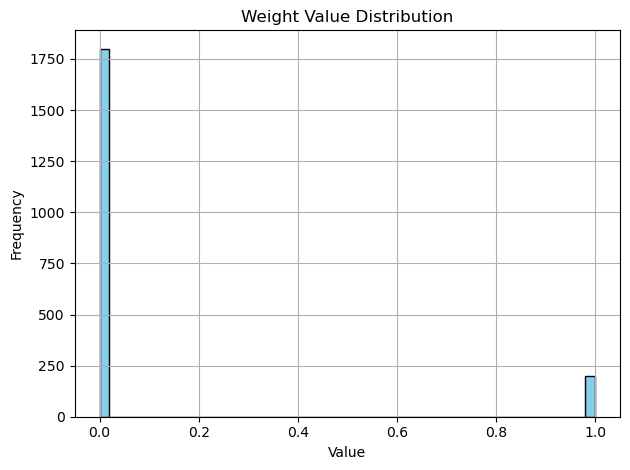

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

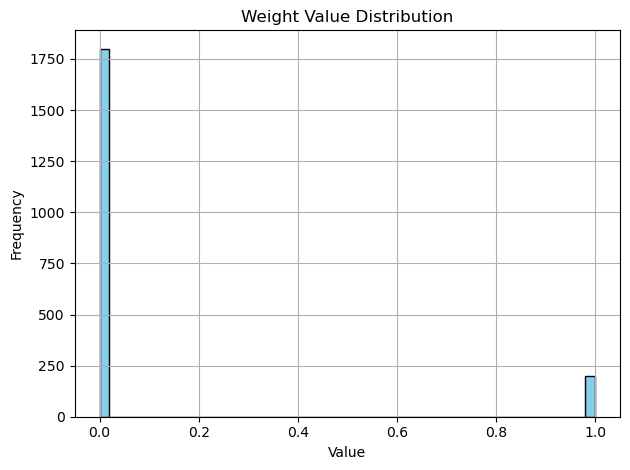

epoch-0   lr=['0.0100000'], tr/val_loss: 10.153987/  3.505270, val:  45.00%, val_best:  45.00%, tr:  30.05%, tr_best:  30.05%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  3.912201/  2.344226, val:  33.75%, val_best:  45.00%, tr:  33.34%, tr_best:  33.34%
epoch-2   lr=['0.0100000'], tr/val_loss:  3.011625/  3.048011, val:  42.92%, val_best:  45.00%, tr:  35.70%, tr_best:  35.70%
epoch-3   lr=['0.0100000'], tr/val_loss:  3.398297/  3.618429, val:  32.08%, val_best:  45.00%, tr:  35.45%, tr_best:  35.70%
epoch-4   lr=['0.0100000'], tr/val_loss:  3.244376/  4.590045, val:  28.33%, val_best:  45.00%, tr:  36.38%, tr_best:  36.38%
epoch-5   lr=['0.0100000'], tr/val_loss:  3.527141/  4.141492, val:  31.25%, val_best:  45.00%, tr:  34.07%, tr_best:  36.38%
epoch-6   lr=['0.0100000'], tr/val_loss:  3.608916/  2.406052, val:  35.83%, val_best:  45.00%, tr:  35.68%, tr_best:  36.38%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▃▅▅▁▆▄▃▅▃▃▁▆▆▄▄▅▂▅▃▅▇▇▇▂▄▁█▇▇▅▃▆▅▂█▂▇▇▅▆
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁███████████████████████████████████████


wandb: Agent Starting Run: 4aa1rg4z with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path:

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_170334_985', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

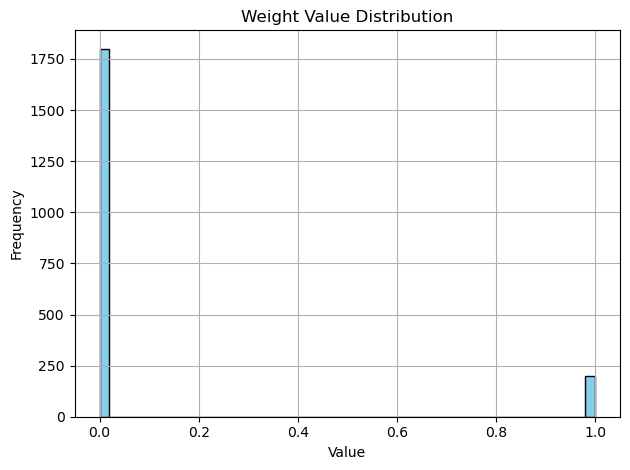

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

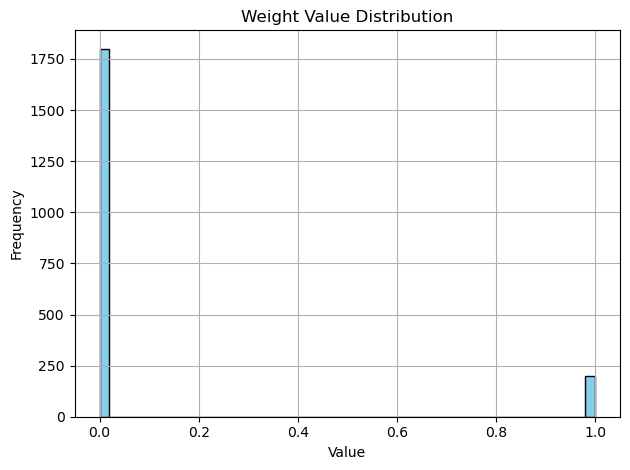

epoch-0   lr=['0.0001000'], tr/val_loss:  2.267089/  2.243942, val:  30.83%, val_best:  30.83%, tr:  24.30%, tr_best:  24.30%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0001000'], tr/val_loss:  2.224640/  2.210950, val:  40.42%, val_best:  40.42%, tr:  34.05%, tr_best:  34.05%
epoch-2   lr=['0.0001000'], tr/val_loss:  2.182151/  2.177765, val:  47.92%, val_best:  47.92%, tr:  41.07%, tr_best:  41.07%
epoch-3   lr=['0.0001000'], tr/val_loss:  2.160099/  2.161647, val:  37.08%, val_best:  47.92%, tr:  43.34%, tr_best:  43.34%
epoch-4   lr=['0.0001000'], tr/val_loss:  2.144599/  2.150562, val:  42.08%, val_best:  47.92%, tr:  42.50%, tr_best:  43.34%
epoch-5   lr=['0.0001000'], tr/val_loss:  2.131795/  2.135779, val:  51.25%, val_best:  51.25%, tr:  47.79%, tr_best:  47.79%
epoch-6   lr=['0.0001000'], tr/val_loss:  2.109720/  2.116544, val:  51.25%, val_best:  51.25%, tr:  55.14%, tr_best:  55.14%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▁▂▂▂▅▅▄▇▅▄▅▇▃▅▅▅▅▅▄▄▇▆▆▅▅▄▆▆▄▄▅▄▆▇▇▄█▅▄
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁███████████████████████████████████████
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: fxo6zg35 with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_175124_099', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

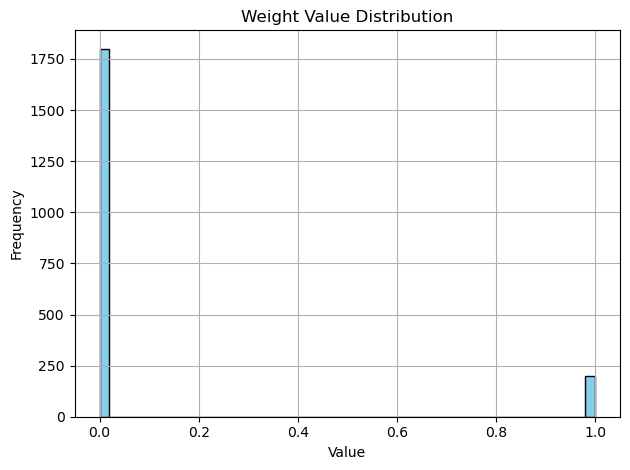

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

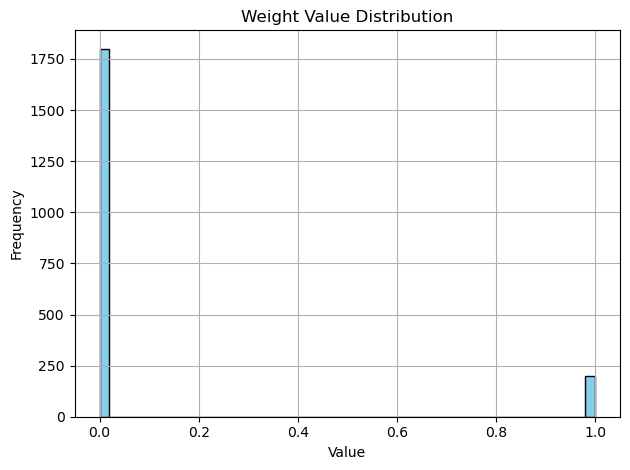

epoch-0   lr=['0.0100000'], tr/val_loss:  4.994536/  3.975198, val:  40.83%, val_best:  40.83%, tr:  31.07%, tr_best:  31.07%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  3.161656/  2.996871, val:  26.25%, val_best:  40.83%, tr:  36.34%, tr_best:  36.34%
epoch-2   lr=['0.0100000'], tr/val_loss:  2.554719/  1.861035, val:  45.83%, val_best:  45.83%, tr:  40.50%, tr_best:  40.50%
epoch-3   lr=['0.0100000'], tr/val_loss:  2.318799/  2.558620, val:  39.58%, val_best:  45.83%, tr:  41.88%, tr_best:  41.88%
epoch-4   lr=['0.0100000'], tr/val_loss:  2.288043/  2.355716, val:  32.92%, val_best:  45.83%, tr:  42.55%, tr_best:  42.55%
epoch-5   lr=['0.0100000'], tr/val_loss:  2.281329/  2.608114, val:  35.00%, val_best:  45.83%, tr:  41.27%, tr_best:  42.55%
epoch-6   lr=['0.0100000'], tr/val_loss:  2.206636/  3.144310, val:  32.50%, val_best:  45.83%, tr:  42.39%, tr_best:  42.55%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▃▄▅▆▄▅▃▄▅▆▃▄▃▆▅▆▃▆▆▃▆▃▇▅▃▁▆▅▄▅▆▃▆▃█▃▆▄▄▂
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁█████████████████████████████████████


wandb: Agent Starting Run: 3ngwwlw0 with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path:

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_183906_122', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

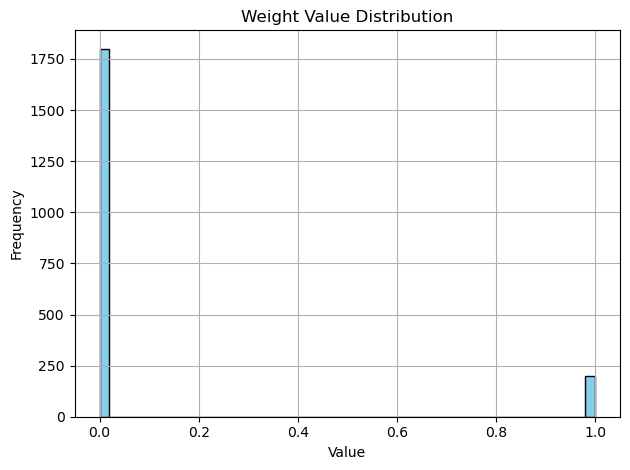

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

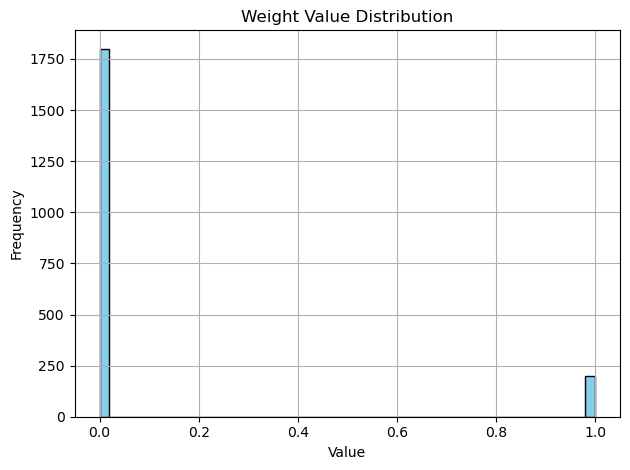

epoch-0   lr=['0.0001000'], tr/val_loss:  2.316852/  2.321029, val:  10.83%, val_best:  10.83%, tr:  11.84%, tr_best:  11.84%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0001000'], tr/val_loss:  2.308362/  2.306838, val:  10.83%, val_best:  10.83%, tr:  14.37%, tr_best:  14.37%
epoch-2   lr=['0.0001000'], tr/val_loss:  2.302606/  2.313982, val:  12.92%, val_best:  12.92%, tr:  13.43%, tr_best:  14.37%
epoch-3   lr=['0.0001000'], tr/val_loss:  2.315658/  2.327683, val:   9.17%, val_best:  12.92%, tr:  10.64%, tr_best:  14.37%
epoch-4   lr=['0.0001000'], tr/val_loss:  2.339958/  2.351213, val:   6.25%, val_best:  12.92%, tr:   9.82%, tr_best:  14.37%
epoch-5   lr=['0.0001000'], tr/val_loss:  2.346500/  2.346857, val:   7.50%, val_best:  12.92%, tr:  10.11%, tr_best:  14.37%
epoch-6   lr=['0.0001000'], tr/val_loss:  2.343190/  2.348231, val:  10.83%, val_best:  12.92%, tr:  10.45%, tr_best:  14.37%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▆▅▁▃▅▅▂▂█▂▅▅▅▃▅▃▂▆▁▅▂▃▁▃▃▂▅▅▁▂▂▂▅▂▁▃▂▃▂▃
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁█████████████████████████████████████
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁█████████████████████████████████
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁███████████████████████████████████████
perc_999_scale_exp_8bit_1w,▁███████████████████████████████████████
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: zjs9hsmd with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_192635_877', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

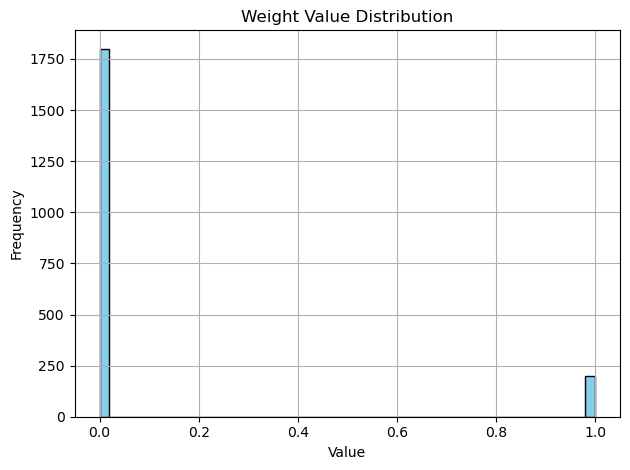

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

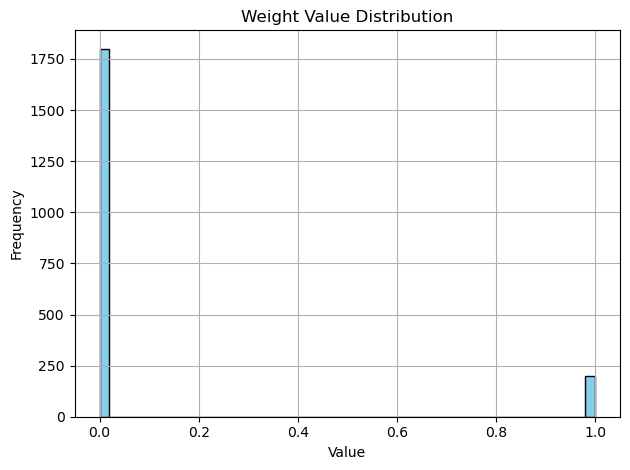

epoch-0   lr=['0.0100000'], tr/val_loss: 13.720415/ 10.077564, val:  35.83%, val_best:  35.83%, tr:  29.30%, tr_best:  29.30%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  5.780292/  7.221319, val:  29.58%, val_best:  35.83%, tr:  36.38%, tr_best:  36.38%
epoch-2   lr=['0.0100000'], tr/val_loss:  3.688070/  4.212902, val:  33.33%, val_best:  35.83%, tr:  38.82%, tr_best:  38.82%
epoch-3   lr=['0.0100000'], tr/val_loss:  3.075706/  2.678191, val:  35.83%, val_best:  35.83%, tr:  34.82%, tr_best:  38.82%
epoch-4   lr=['0.0100000'], tr/val_loss:  3.715335/  4.717019, val:  31.25%, val_best:  35.83%, tr:  36.23%, tr_best:  38.82%
epoch-5   lr=['0.0100000'], tr/val_loss:  2.997339/  3.740963, val:  18.75%, val_best:  35.83%, tr:  34.70%, tr_best:  38.82%
epoch-6   lr=['0.0100000'], tr/val_loss:  2.562225/  3.410618, val:  28.33%, val_best:  35.83%, tr:  33.59%, tr_best:  38.82%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▇▄▅▂▂▂▅▅▂▄▁▅▆▅▁▇▂▅▇▅█▆▄▂▂▅▆▃▄▃▃▇▅▂▅▃▅▃▄▅
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁███████████████████████████████████
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅█▅▅▅▅▅▅▅▅▅▅


wandb: Agent Starting Run: 7u3y38dd with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_201423_721', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

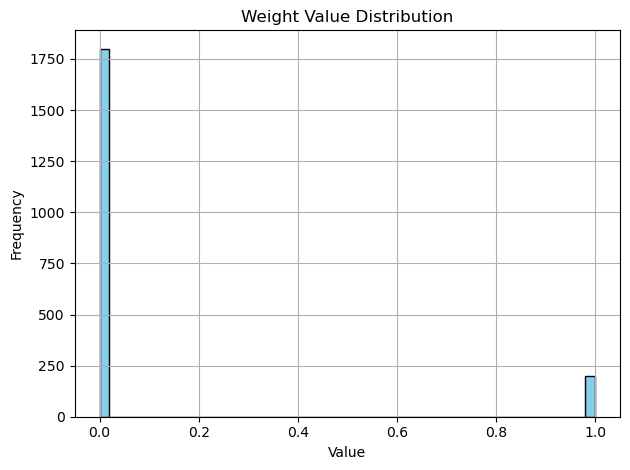

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

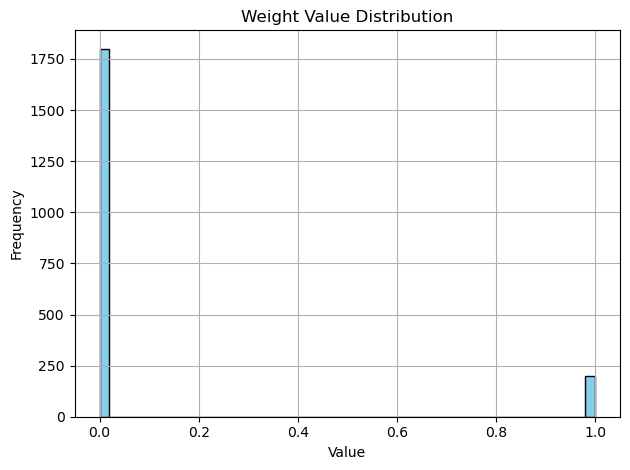

epoch-0   lr=['0.0100000'], tr/val_loss: 12.297043/  7.836922, val:  41.25%, val_best:  41.25%, tr:  33.98%, tr_best:  33.98%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  5.187722/  8.413240, val:  39.17%, val_best:  41.25%, tr:  45.48%, tr_best:  45.48%
epoch-2   lr=['0.0100000'], tr/val_loss:  4.534980/  3.319241, val:  47.50%, val_best:  47.50%, tr:  48.11%, tr_best:  48.11%
epoch-3   lr=['0.0100000'], tr/val_loss:  4.282146/  3.365345, val:  48.33%, val_best:  48.33%, tr:  47.88%, tr_best:  48.11%
epoch-4   lr=['0.0100000'], tr/val_loss:  4.649908/  4.547627, val:  33.75%, val_best:  48.33%, tr:  45.18%, tr_best:  48.11%
epoch-5   lr=['0.0100000'], tr/val_loss:  4.001478/  4.258483, val:  36.67%, val_best:  48.33%, tr:  48.48%, tr_best:  48.48%
epoch-6   lr=['0.0100000'], tr/val_loss:  3.746220/  4.521548, val:  40.83%, val_best:  48.33%, tr:  47.95%, tr_best:  48.48%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▄▂▄▃▅▄▅▄▄▅▄▅▅▆▅▅▅▄█▃▇▇▇▄▇▅▄▅▆▅▅▅▆▂▅▄▅▁▅▃
max_val_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: a1tdpeu3 with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path:

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_210223_451', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

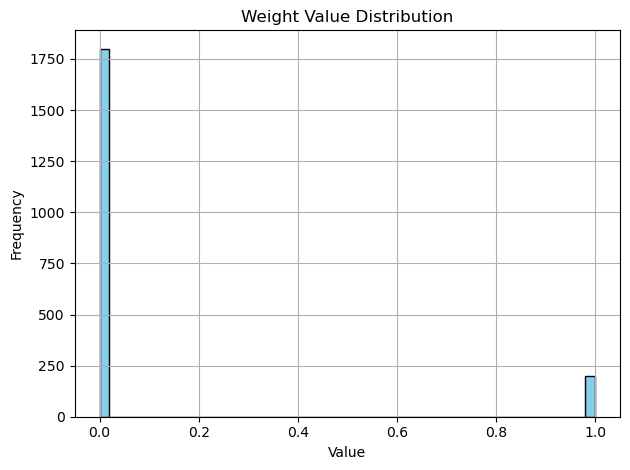

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

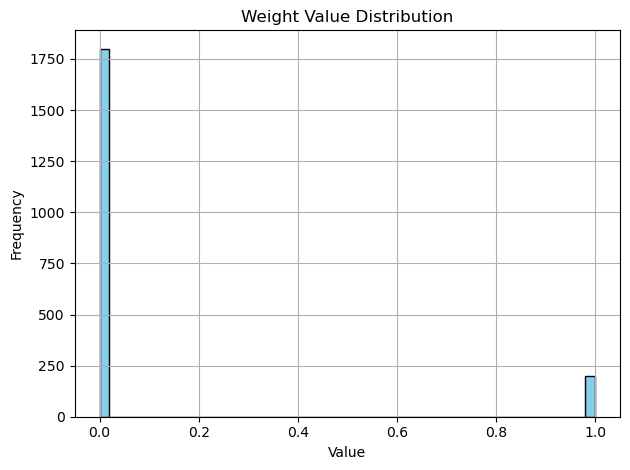

epoch-0   lr=['0.0001000'], tr/val_loss:  2.266077/  2.231898, val:  30.42%, val_best:  30.42%, tr:  23.89%, tr_best:  23.89%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0001000'], tr/val_loss:  2.199035/  2.189693, val:  36.25%, val_best:  36.25%, tr:  39.77%, tr_best:  39.77%
epoch-2   lr=['0.0001000'], tr/val_loss:  2.147879/  2.151542, val:  48.33%, val_best:  48.33%, tr:  46.59%, tr_best:  46.59%
epoch-3   lr=['0.0001000'], tr/val_loss:  2.122266/  2.133276, val:  50.42%, val_best:  50.42%, tr:  52.05%, tr_best:  52.05%
epoch-4   lr=['0.0001000'], tr/val_loss:  2.103840/  2.122596, val:  50.00%, val_best:  50.42%, tr:  50.66%, tr_best:  52.05%
epoch-5   lr=['0.0001000'], tr/val_loss:  2.086026/  2.094521, val:  50.42%, val_best:  50.42%, tr:  53.45%, tr_best:  53.45%
epoch-6   lr=['0.0001000'], tr/val_loss:  2.074349/  2.094644, val:  52.50%, val_best:  52.50%, tr:  54.64%, tr_best:  54.64%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▃▆▃█▆▆▃█▅▃█▆▄▆▅▆▆▇▇▄▅▅▇▆▃▂▅▆▃▇▇▄▂▆▂▄▆▆▆
max_val_scale_exp_8bit_1b,▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████████
max_val_scale_exp_8bit_1w,▁▁▁▁████████████████████████████████████
max_val_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁███
perc_999_scale_exp_8bit_1b,▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████████
perc_999_scale_exp_8bit_1w,▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅███████████
perc_999_scale_exp_8bit_2b,▁▁▁▁▁▁▁▁▁▁▁▁████████████████████████████


wandb: Agent Starting Run: paqzytvr with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.01
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path: 


wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_215020_627', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.01, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num_w

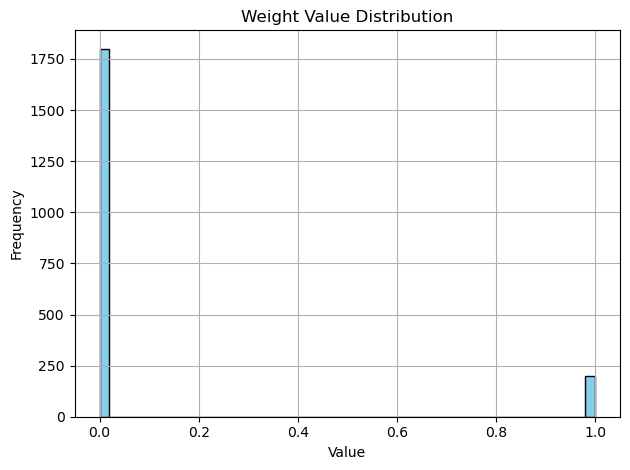

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

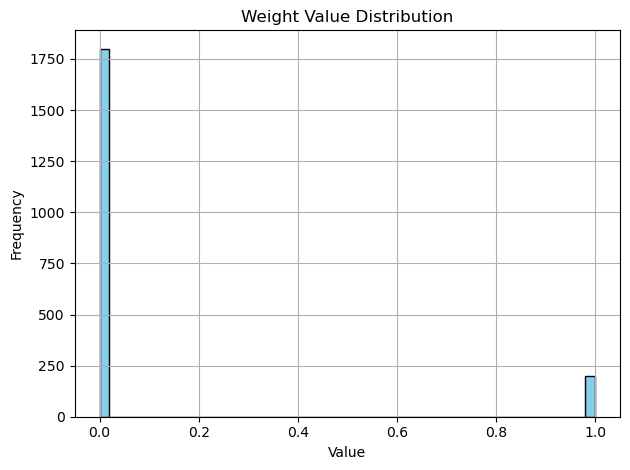

epoch-0   lr=['0.0100000'], tr/val_loss:  4.758175/  2.909017, val:  34.58%, val_best:  34.58%, tr:  27.91%, tr_best:  27.91%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0100000'], tr/val_loss:  2.818953/  3.087469, val:  35.83%, val_best:  35.83%, tr:  35.71%, tr_best:  35.71%
epoch-2   lr=['0.0100000'], tr/val_loss:  2.320714/  2.246005, val:  41.67%, val_best:  41.67%, tr:  40.95%, tr_best:  40.95%
epoch-3   lr=['0.0100000'], tr/val_loss:  2.136905/  2.182326, val:  30.00%, val_best:  41.67%, tr:  41.34%, tr_best:  41.34%
epoch-4   lr=['0.0100000'], tr/val_loss:  2.043024/  2.023135, val:  39.58%, val_best:  41.67%, tr:  43.73%, tr_best:  43.73%
epoch-5   lr=['0.0100000'], tr/val_loss:  2.019552/  2.236542, val:  37.08%, val_best:  41.67%, tr:  42.75%, tr_best:  43.73%
epoch-6   lr=['0.0100000'], tr/val_loss:  1.918393/  2.210314, val:  39.17%, val_best:  41.67%, tr:  44.77%, tr_best:  44.77%
epoch-7   lr=['

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▃▄▇▄▅▇▅▅▁▅▃▆▆▇▅▅▃▆█▃▅▇▇▄▇▅█▆▅▅▄▄▅▅▆▄▆▅▅▆
max_val_scale_exp_8bit_1b,▁▁██████████████████████████████████████
max_val_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_2b,▁▁██████████████████████████████████████
max_val_scale_exp_8bit_2w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3b,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_val_scale_exp_8bit_3w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_1b,▁▁██████████████████████████████████████
perc_999_scale_exp_8bit_1w,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perc_999_scale_exp_8bit_2b,▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████


wandb: Agent Starting Run: 8o593b6l with config:
wandb: 	BATCH: 16
wandb: 	BN_on: False
wandb: 	BPTT_on: False
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 14
wandb: 	OTTT_input_trace_on: False
wandb: 	TIME: 8
wandb: 	UDA_on: False
wandb: 	alpha_uda: 1
wandb: 	bias: True
wandb: 	cfg: [200, 200]
wandb: 	chaching_on: True
wandb: 	convTrue_fcFalse: False
wandb: 	data_path: /data2
wandb: 	ddp_on: False
wandb: 	denoise_on: False
wandb: 	dvs_clipping: 14
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 9
wandb: 	initial_pooling: 1
wandb: 	last_lif: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_layer_sg_width: 4
wandb: 	lif_layer_v_decay: 0.5
wandb: 	lif_layer_v_init: 0
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.5
wandb: 	merge_polarities: True
wandb: 	my_seed: 42
wandb: 	net_print: True
wandb: 	num_workers: 2
wandb: 	optimizer_what: SGD
wandb: 	pin_memory: True
wandb: 	pre_trained: False
wandb: 	pre_trained_path:

wandb: WARNING Config item 'single_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config 

param {'devices': '0', 'single_step': True, 'unique_name': '20250524_223753_576', 'my_seed': 42, 'TIME': 8, 'BATCH': 16, 'IMAGE_SIZE': 14, 'which_data': 'DVS_GESTURE_TONIC', 'data_path': '/data2', 'rate_coding': False, 'lif_layer_v_init': 0, 'lif_layer_v_decay': 0.5, 'lif_layer_v_threshold': 0.5, 'lif_layer_v_reset': 10000, 'lif_layer_sg_width': 4, 'synapse_conv_kernel_size': 3, 'synapse_conv_stride': 1, 'synapse_conv_padding': 1, 'synapse_trace_const1': 1, 'synapse_trace_const2': 0.5, 'pre_trained': False, 'convTrue_fcFalse': False, 'cfg': [200, 200], 'net_print': True, 'pre_trained_path': '', 'learning_rate': 0.0001, 'epoch_num': 100, 'tdBN_on': False, 'BN_on': False, 'surrogate': 'hard_sigmoid', 'BPTT_on': False, 'optimizer_what': 'SGD', 'scheduler_name': 'no', 'ddp_on': False, 'dvs_clipping': 14, 'dvs_duration': 25000, 'DFA_on': True, 'trace_on': False, 'OTTT_input_trace_on': False, 'exclude_class': True, 'merge_polarities': True, 'denoise_on': False, 'extra_train_dataset': 9, 'num

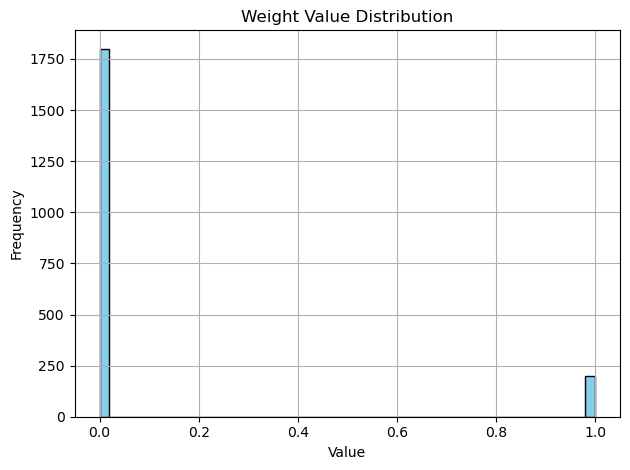

new_weights[i] tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
new_weights[i] tensor([0., 0., 0., 0., 0., 0

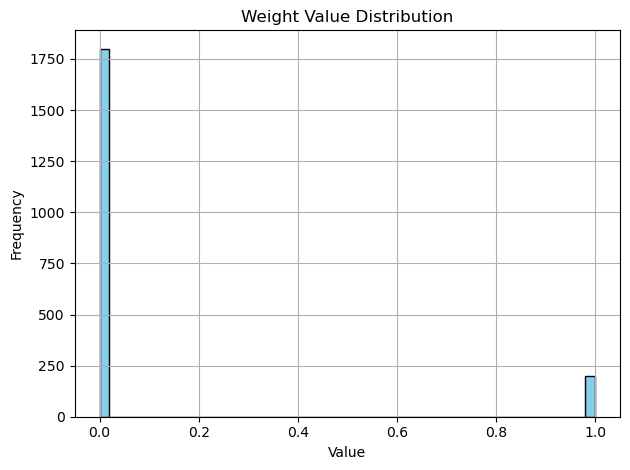

epoch-0   lr=['0.0001000'], tr/val_loss:  2.180427/  2.122329, val:  49.58%, val_best:  49.58%, tr:  41.07%, tr_best:  41.07%
[module.layers.6] weight_fb parameter count: 2,000
[module.layers.10] weight_fb parameter count: 2,000
epoch-1   lr=['0.0001000'], tr/val_loss:  2.070707/  2.079156, val:  50.83%, val_best:  50.83%, tr:  55.52%, tr_best:  55.52%
epoch-2   lr=['0.0001000'], tr/val_loss:  2.053345/  2.088374, val:  52.08%, val_best:  52.08%, tr:  56.55%, tr_best:  56.55%
epoch-3   lr=['0.0001000'], tr/val_loss:  2.037689/  2.062736, val:  55.83%, val_best:  55.83%, tr:  58.32%, tr_best:  58.32%
epoch-4   lr=['0.0001000'], tr/val_loss:  2.038992/  2.065475, val:  52.92%, val_best:  55.83%, tr:  58.57%, tr_best:  58.57%
epoch-5   lr=['0.0001000'], tr/val_loss:  2.057559/  2.094837, val:  54.17%, val_best:  55.83%, tr:  58.38%, tr_best:  58.57%
epoch-6   lr=['0.0001000'], tr/val_loss:  2.058916/  2.077852, val:  53.75%, val_best:  55.83%, tr:  59.86%, tr_best:  59.86%
epoch-7   lr=['

In [6]:
# sweep 하는 코드, 위 셀 주석처리 해야 됨.

# 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

unique_name_hyper = 'main'
sweep_configuration = {
    'method': 'bayes', # 'random', 'bayes', 'grid'
    'name': f'my_snn_sweep{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}',
    'metric': {'goal': 'maximize', 'name': 'val_acc_best'},
    'parameters': 
    {
        # "devices": {"values": ["1"]},
        "single_step": {"values": [True]},
        # "unique_name": {"values": [unique_name_hyper]},
        "my_seed": {"values": [42]},
        "TIME": {"values": [8]},
        "BATCH": {"values": [16]},
        "IMAGE_SIZE": {"values": [14]},
        "which_data": {"values": ['DVS_GESTURE_TONIC']},
        "data_path": {"values": ['/data2']},
        "rate_coding": {"values": [False]},
        "lif_layer_v_init": {"values": [0.0]},
        "lif_layer_v_decay": {"values": [0.5]},
        "lif_layer_v_threshold": {"values": [0.5]},
        "lif_layer_v_reset": {"values": [10000.0]},
        "lif_layer_sg_width": {"values": [4.0]},

        "synapse_conv_kernel_size": {"values": [3]},
        "synapse_conv_stride": {"values": [1]},
        "synapse_conv_padding": {"values": [1]},

        "synapse_trace_const1": {"values": [1]},
        "synapse_trace_const2": {"values": [0.5]},

        "pre_trained": {"values": [False]},
        "convTrue_fcFalse": {"values": [False]},

        "cfg": {"values": [[200,200]]},

        "net_print": {"values": [True]},

        "pre_trained_path": {"values": [""]},
        "learning_rate": {"values": [0.0001,0.01]}, 
        "epoch_num": {"values": [100]}, 
        "tdBN_on": {"values": [False]},
        "BN_on": {"values": [False]},

        "surrogate": {"values": ['hard_sigmoid']},

        "BPTT_on": {"values": [False]},

        "optimizer_what": {"values": ['SGD']},
        "scheduler_name": {"values": ['no']},

        "ddp_on": {"values": [False]},

        "dvs_clipping": {"values": [14]}, 

        "dvs_duration": {"values": [25_000]}, 

        "DFA_on": {"values": [True]},

        "trace_on": {"values": [False]},
        "OTTT_input_trace_on": {"values": [False]},

        "exclude_class": {"values": [True]},

        "merge_polarities": {"values": [True]},
        "denoise_on": {"values": [False]},

        "extra_train_dataset": {"values": [9]},

        "num_workers": {"values": [2]},
        "chaching_on": {"values": [True]},
        "pin_memory": {"values": [True]},

        "UDA_on": {"values": [False]},
        "alpha_uda": {"values": [1.0]},

        "bias": {"values": [True]},

        "last_lif": {"values": [False]},

        "temporal_filter": {"values": [5]},
        "initial_pooling": {"values": [1]},

        "temporal_filter_accumulation": {"values": [False]},

        "quantize_bit_list_0": {"values": [8]},
        "quantize_bit_list_1": {"values": [8]},
        "quantize_bit_list_2": {"values": [8]},

        "scale_exp_1w": {"values": [-11,-10,-9]},
        "scale_exp_1b": {"values": [-11,-10,-9,-8,-7,-6]},
        "scale_exp_2w": {"values": [-10,-9,-8,-7,-6]},
        "scale_exp_2b": {"values": [-10,-9,-8]},
        "scale_exp_3w": {"values": [-10,-9,-8,-7,-6]},
        "scale_exp_3b": {"values": [-10,-9,-8,-7,-6]},
     }
}

def hyper_iter():
    ### my_snn control board ########################
    wandb.init(save_code=False, dir='/data2/bh_wandb', tags=["sweep"])

    my_snn_system(  
        devices  =  "0",
        single_step  =  wandb.config.single_step,
        unique_name  =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S_") + f"{datetime.datetime.now().microsecond // 1000:03d}",
        my_seed  =  wandb.config.my_seed,
        TIME  =  wandb.config.TIME,
        BATCH  =  wandb.config.BATCH,
        IMAGE_SIZE  =  wandb.config.IMAGE_SIZE,
        which_data  =  wandb.config.which_data,
        data_path  =  wandb.config.data_path,
        rate_coding  =  wandb.config.rate_coding,
        lif_layer_v_init  =  wandb.config.lif_layer_v_init,
        lif_layer_v_decay  =  wandb.config.lif_layer_v_decay,
        lif_layer_v_threshold  =  wandb.config.lif_layer_v_threshold,
        lif_layer_v_reset  =  wandb.config.lif_layer_v_reset,
        lif_layer_sg_width  =  wandb.config.lif_layer_sg_width,
        synapse_conv_kernel_size  =  wandb.config.synapse_conv_kernel_size,
        synapse_conv_stride  =  wandb.config.synapse_conv_stride,
        synapse_conv_padding  =  wandb.config.synapse_conv_padding,
        synapse_trace_const1  =  wandb.config.synapse_trace_const1,
        synapse_trace_const2  =  wandb.config.synapse_trace_const2,
        pre_trained  =  wandb.config.pre_trained,
        convTrue_fcFalse  =  wandb.config.convTrue_fcFalse,
        cfg  =  wandb.config.cfg,
        net_print  =  wandb.config.net_print,
        pre_trained_path  =  wandb.config.pre_trained_path,
        learning_rate  =  wandb.config.learning_rate,
        epoch_num  =  wandb.config.epoch_num,
        tdBN_on  =  wandb.config.tdBN_on,
        BN_on  =  wandb.config.BN_on,
        surrogate  =  wandb.config.surrogate,
        BPTT_on  =  wandb.config.BPTT_on,
        optimizer_what  =  wandb.config.optimizer_what,
        scheduler_name  =  wandb.config.scheduler_name,
        ddp_on  =  wandb.config.ddp_on,
        dvs_clipping  =  wandb.config.dvs_clipping,
        dvs_duration  =  wandb.config.dvs_duration,
        DFA_on  =  wandb.config.DFA_on,
        trace_on  =  wandb.config.trace_on,
        OTTT_input_trace_on  =  wandb.config.OTTT_input_trace_on,
        exclude_class  =  wandb.config.exclude_class,
        merge_polarities  =  wandb.config.merge_polarities,
        denoise_on  =  wandb.config.denoise_on,
        extra_train_dataset  =  wandb.config.extra_train_dataset,
        num_workers  =  wandb.config.num_workers,
        chaching_on  =  wandb.config.chaching_on,
        pin_memory  =  wandb.config.pin_memory,
        UDA_on  =  wandb.config.UDA_on,
        alpha_uda  =  wandb.config.alpha_uda,
        bias  =  wandb.config.bias,
        last_lif  =  wandb.config.last_lif,
        temporal_filter  =  wandb.config.temporal_filter,
        initial_pooling  =  wandb.config.initial_pooling,
        temporal_filter_accumulation  =  wandb.config.temporal_filter_accumulation,
        quantize_bit_list  =  [wandb.config.quantize_bit_list_0,wandb.config.quantize_bit_list_1,wandb.config.quantize_bit_list_2],
        scale_exp = [[wandb.config.scale_exp_1w,wandb.config.scale_exp_1b],[wandb.config.scale_exp_2w,wandb.config.scale_exp_2b],[wandb.config.scale_exp_3w,wandb.config.scale_exp_3b]],
                        ) 
    # sigmoid와 BN이 있어야 잘된다.
    # average pooling
    # 이 낫다. 
    
    # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
    ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True

# sweep_id = '33vkjz96'
sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
wandb.agent(sweep_id, function=hyper_iter, count=10000, project=f'my_snn {unique_name_hyper}')
